In [1]:
USE_IMAGES_INSTEAD_OF_COMPUTING = True

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.spatial.distance import euclidean
from IPython.display import Image
plt.rcParams['figure.figsize'] = [10, 5]

# For results repeatability
np.random.seed(0)

# Utils

### Plotting function

In [3]:
def plotMeanAndStd(stats, x, color='b', ax = None, legend=None):
    """
    Input : array of tuples (mean std) and their x coordinates
    """
    mean = np.array([s[0] for s in stats])
    standard_dev = np.array([s[1] for s in stats])
    if ax == None :
        plt.plot(x, mean, c=color,label=legend)
        plt.fill_between(x, mean-standard_dev, mean+standard_dev, alpha=0.2, color=color)
    else:
        ax.plot(x, mean, c=color,label=legend)
        ax.fill_between(x, mean-standard_dev, mean+standard_dev, alpha=0.2, color=color)  

### Error measure

In [4]:
def error(predicted_labels, real_labels, loss="euclidean"):
    """
    Input: numpy array containing respectively the labels an algorithm predicted, and the real labels corresponding
    to the data. Type of loss we want to use.
    
    Output: float, the computed loss.
    """
    if loss == "euclidean": return euclidean(predicted_labels, real_labels)
    elif loss == "manhattan": return sum(abs(predicted_labels - real_labels))
    
    

In [5]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

### Features normalization

We add the possibility to perform data normalization with scikit-learn's scaler to avoid having overweighted features.

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
def normalize(dataset):
    columns = dataset.columns
    scaler = StandardScaler()
    scaler.fit(dataset)
    dataset[columns] = scaler.transform(dataset[columns])
    return dataset

### Identify the features considered as most important from decision tree

The goal of this section is to be able to identify the data features that decision trees identify as most signficant. This could be useful, in particular to weight features according to their importance when performing KNN classication.

In [8]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

def features_importance(training_features, training_labels, criterion='gini',
                        splitter='best', visualize = False, nb_top=5):
    """
    Input: training features and labels, decision tree's parameters, whether we want to visualize feature's
    importance
    
    Output: a dictionary giving each feature a score according to its importance in the decision tree
    """
    
    classifier = DecisionTreeClassifier(criterion=criterion, splitter=splitter)
    classifier.fit(training_features, training_labels)
    features_importances = classifier.feature_importances_
    
    importance = dict()
    cols = training_features.columns
    for i,v in enumerate(features_importances):
        importance[cols[i]] = v
    
    if visualize:
        # Say which features are most important
        ordered_features = sorted(importance.keys(), key = lambda k:(importance[k])) 
        ordered_features.reverse()
        for i in range(nb_top):
            feature = ordered_features[i]
            print(f"Feature ranked {i + 1} is {feature} with score {importance[feature]}")
            
        # Plot feature importance
        plt.bar([x for x in range(len(features_importances))], features_importances)
        plt.show()
    
    return importance

### Features weighting

In [9]:
def weight_features(dataset, weights):
    """
    Input: a dataset (pandas dataframe), and a dictionary giving each dataset's feature a weight
    according to their importance
    
    Output: None, but dataset's features have been multiplied by their weight to take into account the
    differences in their importance
    """
    for feature in weights:
        dataset[feature] *= weights[feature]
        

# Dataset preprocessing

## Dataset 1

A function to upload and preprocess data in the "adults" format. As a first approach we simply remove rows with missing values.

In [10]:
def get_clean_dataset1(data_file, test=False):
    dataset = pd.read_csv(data_file, header=None)
    dataset.columns = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","salary"]
    dataset = dataset[(dataset!=" ?").all(axis=1)].reset_index(drop=True)
    df_strings = dataset.select_dtypes(['object'])
    dataset[df_strings.columns] = df_strings.apply(lambda x: x.str.strip())
    clean_dataset = pd.DataFrame(dataset["age"])
    for col in dataset.columns[1:-1]:
        if(dataset[col].dtype =='O'):
            clean_dataset = clean_dataset.join(pd.get_dummies(dataset[col], prefix=col))
        else:
            clean_dataset = clean_dataset.join(dataset[col])
    
    if test: labels = (dataset["salary"]==">50K.")*1
    else: labels = (dataset["salary"]==">50K")*1
    return clean_dataset, labels

### Training / Validation dataset

In [11]:
dataset_adult, labels_adult = get_clean_dataset1("data/adult.data")

### Test dataset

In [12]:
test_dataset_adult, test_labels_adult = get_clean_dataset1("data/adult.test", test=True)

In [13]:
# There is a 'missing' column in the adult test dataset because it does not contain people born in Holand-Netherlands
# We virtually add one to be able to run all algorithms
test_dataset_adult['native-country_Holand-Netherlands'] = 0

### Understanding the dataset

####  What is the influence of the features one can think of as important?

We try to visualize if some basic features one can easily think of seem to have an influence on salary (like sex or education).

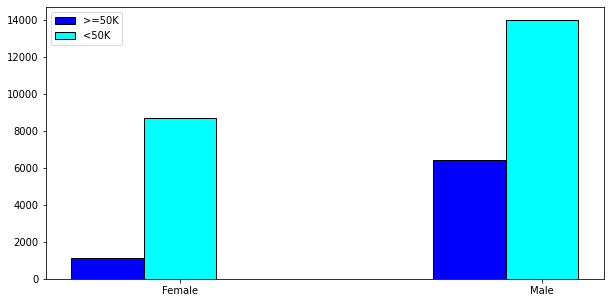

Proportion of Females above 50k: 0.11367818442036394
Proportion of Males above 50k: 0.3138370951913641


In [14]:
male_low = dataset_adult[(dataset_adult["sex_Male"]==1) & (labels_adult==0)].shape[0]
male_high = dataset_adult[(dataset_adult["sex_Male"]==1) & (labels_adult==1)].shape[0]
female_low = dataset_adult[(dataset_adult["sex_Female"]==1) & (labels_adult==0)].shape[0]
female_high = dataset_adult[(dataset_adult["sex_Female"]==1) & (labels_adult==1)].shape[0]
fisher_tab = np.array([[male_low, male_high], [female_low, female_high]])

barWidth = 0.2
bars1 = [female_high, male_high]
bars2 = [female_low, male_low]
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black',label='>=50K')
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', label='<50K')

plt.xticks([r + barWidth for r in range(len(bars1))], ['Female', 'Male'])
plt.legend()
 
plt.show()

print(f"Proportion of Females above 50k: {female_high / (female_low + female_high)}")
print(f"Proportion of Males above 50k: {male_high / (male_low + male_high)}")

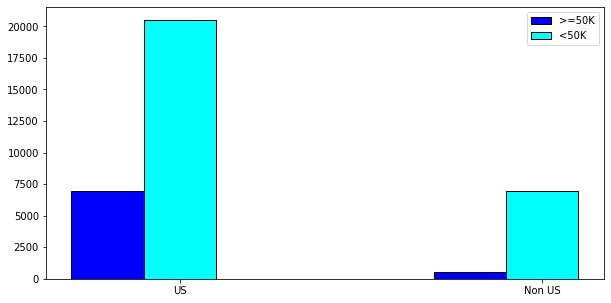

Proportion of US born above 50k: 0.254326643397324
Proportion of non US born above 50k: 0.1930022573363431


In [15]:
US_low = dataset_adult[(dataset_adult["native-country_United-States"]==1) & (labels_adult==0)].shape[0]
US_high = dataset_adult[(dataset_adult["native-country_United-States"]==1) &(labels_adult==1)].shape[0]
non_US_low = dataset_adult[(dataset_adult["native-country_United-States"]==0) & (labels_adult==0)].shape[0]
non_US_high = dataset_adult[(dataset_adult["native-country_United-States"]==0) & (labels_adult==1)].shape[0]
barWidth = 0.2
bars1 = [US_high, non_US_high]
bars2 = [US_low, US_high]
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black',label='>=50K')
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', label='<50K')

plt.xticks([r + barWidth for r in range(len(bars1))], ['US', 'Non US'])
plt.legend()
 
plt.show()

print(f"Proportion of US born above 50k: {US_high / (US_low + US_high)}")
print(f"Proportion of non US born above 50k: {non_US_high / (non_US_low + non_US_high)}")

#### See cumulative importance of each feature

In [16]:
weights = features_importance(dataset_adult, labels_adult, criterion='gini',
                        splitter='best', visualize = False, nb_top=5)

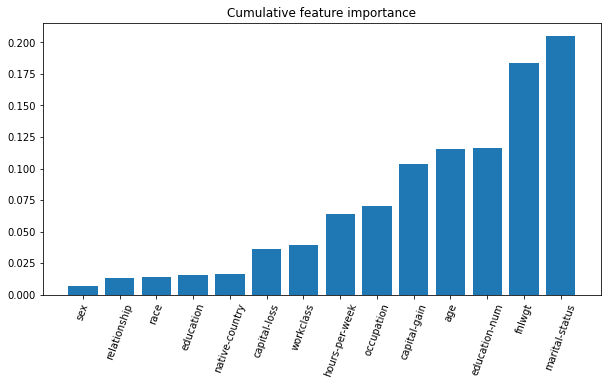

In [17]:
d = {}
for c, v in sorted(weights.items(), key=lambda item: item[1]):
    c =c.split('_')[0]
    if c in d.keys():
        d[c] += v
    else:
        d[c] = v


d=dict(sorted(d.items(), key=lambda item: item[1]))
vars_to_plot = list(d.keys())[:-5]
plt.bar(range(len(d)), list(d.values()), align='center')
plt.xticks(range(len(d)), list(d.keys()),rotation=70)
plt.title("Cumulative feature importance")
pass

#### Visualize each feature's influence

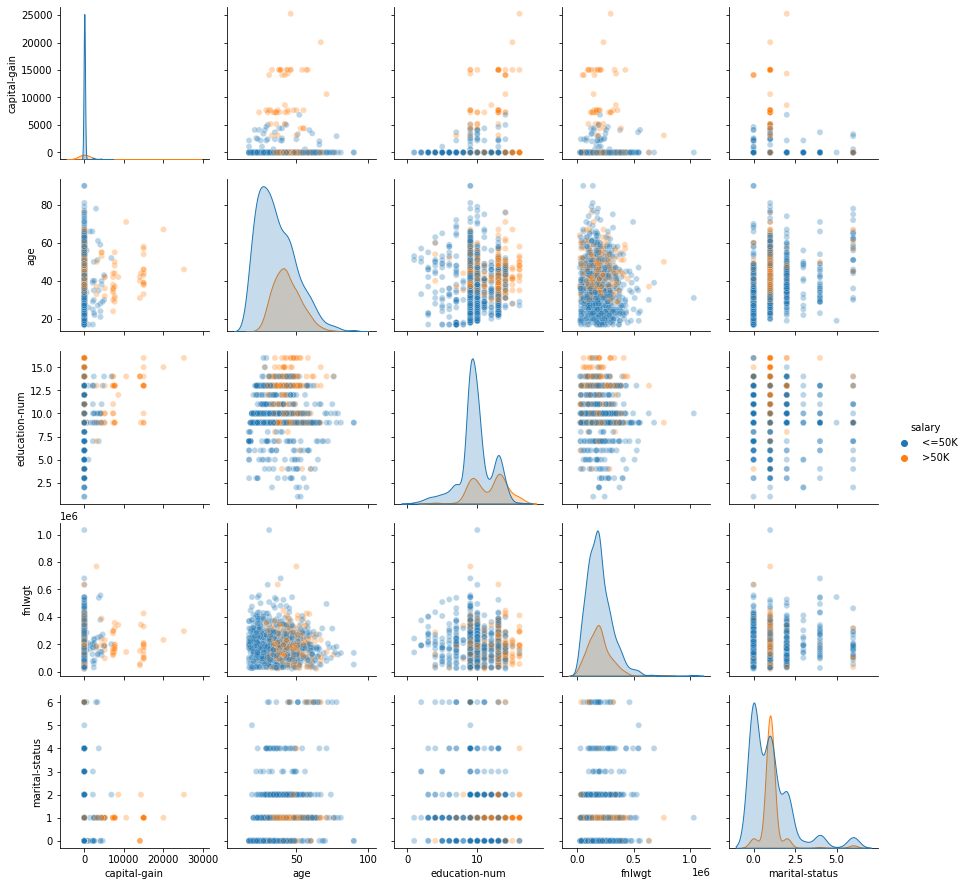

In [18]:
# Get seaborn to plot the pair graph so get a better understanding of the data
import seaborn as sns
def getDatasetWithNoOneHot():
    dataset = pd.read_csv("data/adult.data", header=None)
    dataset.columns = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","salary"]
    dataset = dataset[(dataset!=" ?").all(axis=1)].reset_index(drop=True)
    df_strings = dataset.select_dtypes(['object'])
    dataset[df_strings.columns] = df_strings.apply(lambda x: x.str.strip())

    for col in dataset.columns[1:-1]:
        if(dataset[col].dtype !='int64'):
            dataset[col]= pd.factorize(dataset[col].astype("category"))[0]
    return dataset
sns.pairplot(getDatasetWithNoOneHot()[:1000], hue = "salary",vars=['capital-gain', 'age', 'education-num', 'fnlwgt', 'marital-status'],plot_kws = {'alpha': 0.3})

## Dataset 2

In [19]:
def get_clean_dataset2(data_file):
    dataset = pd.read_csv(data_file, header=None)
    dataset.columns = ["white_king_column","white_king_row","white_rook_column","white_rook_row","black_king_column","black_king_row", "outcome"]
    df_strings = dataset.select_dtypes(['object'])
    dataset[df_strings.columns] = df_strings.apply(lambda x: x.str.strip())
    for col in dataset.columns[0:-1:2]:
        dataset[col] = dataset[col].apply(lambda x: ord(x)-ord('a'))
    labels = (dataset["outcome"]!="draw")*1
    del dataset["outcome"]
    return dataset, labels

### Training / Validation dataset

In [20]:
dataset_chess, labels_chess = get_clean_dataset2("data/krkopt.data")

### Test dataset

In [21]:
test_dataset_chess, test_labels_chess = get_clean_dataset2("data/krkopt.test")

### Understanding the dataset

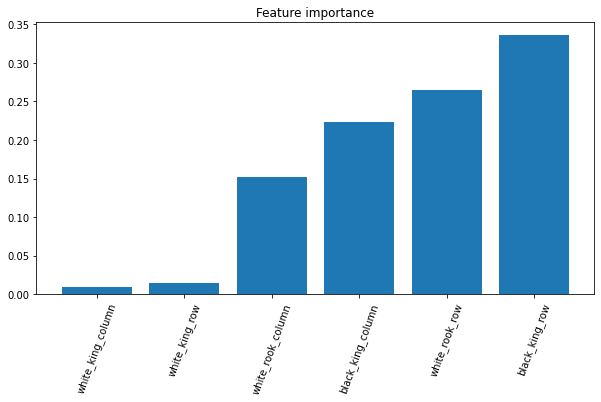

In [22]:
weights = features_importance(dataset_chess, labels_chess, criterion='gini',
                        splitter='best', visualize = False, nb_top=6)
d=dict(sorted(weights.items(), key=lambda item: item[1]))
vars_to_plot = list(d.keys())[:-5]
plt.bar(range(len(d)), list(d.values()), align='center')
plt.xticks(range(len(d)), list(d.keys()),rotation=70)
plt.title("Feature importance")
pass

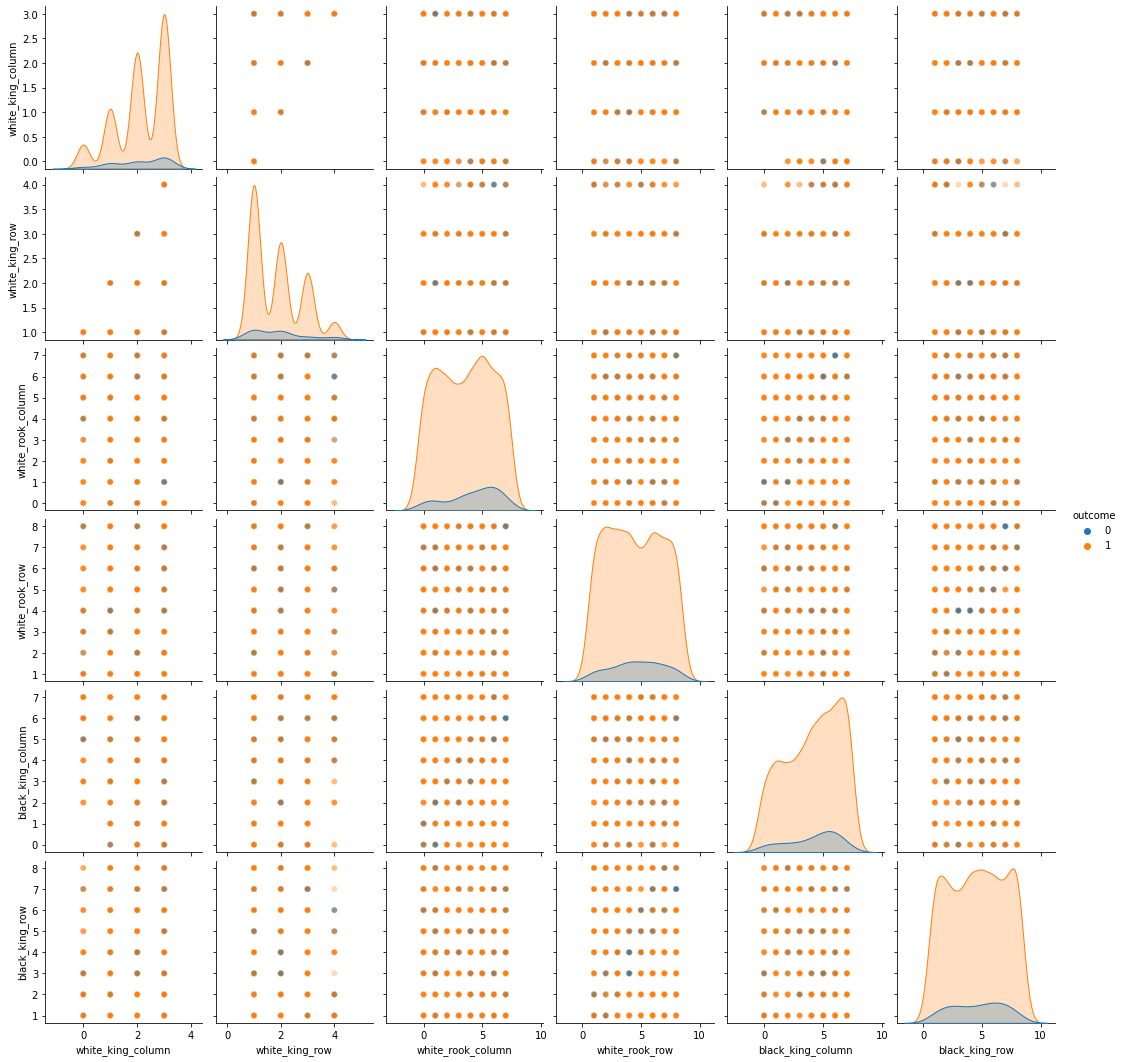

In [23]:
import seaborn as sns
sns.pairplot(dataset_chess[:1000].join(labels_chess), hue = "outcome",plot_kws = {'alpha': 0.3})

# Cross validation

In [24]:
def cross_validation(algo, dataset_, labels_, loss_="manhattan", folds = 5, algo_kwargs={}):
    """
    Input : Predictor function that works by supplying training set and labels and test set and return predicted labels
            dataset  and corresponding labels
            folds
            algo_kwargs : a dict with additional params for the algo : ex. {'n_neighbors':5}
    Output : Precision mean and variance
    """
    dataset_size = dataset_.shape[0]
    group_ids = np.tile(np.arange(folds),int(dataset_size/folds)+1)[:dataset_size]
    np.random.shuffle(group_ids)
    training_precisions = []
    validation_precisions = []
    for N in range(folds):
        training_set = dataset_[group_ids != N].reset_index(drop=True)
        training_labels = labels_[group_ids != N].reset_index(drop=True)
        test_set = dataset_[group_ids == N].reset_index(drop=True)
        test_labels = labels_[group_ids == N].reset_index(drop=True)
        # Training error
        training_predicted_labels = algo(training_set, training_labels, training_set, **algo_kwargs)
        training_precisions += [(len(training_labels) - error(training_predicted_labels, training_labels, loss = loss_))/len(training_labels)]
    
        
        # Validation error
        validation_predicted_labels = algo(training_set, training_labels, test_set, **algo_kwargs)
        validation_precisions += [(len(test_labels) - error(validation_predicted_labels, test_labels, loss = loss_))/len(test_labels)]
    
    
    return (np.mean(training_precisions), np.std(training_precisions), np.mean(validation_precisions), np.std(validation_precisions))

In [25]:
def data_size_influence(algo, dataset_, labels_, Ns=[], loss_="manhattan", folds = 5, algo_kwargs={}, show_time=False, visualize=True):
    
    nrows = dataset_.shape[0]
    mean_trainings = []
    std_trainings = []
    mean_validations = []
    std_validations = []
    
    if show_time: times = []
    
    for N in Ns:
        indices = list(np.random.choice(nrows, N))
        d = dataset_.iloc[indices]
        l = labels_.iloc[indices]
        
        if show_time: t = time.time()
        mean_training, std_training, mean_validation, std_validation = cross_validation(algo, d, l, folds = folds, algo_kwargs=algo_kwargs)
        if show_time: times.append(time.time() - t)
        
        mean_trainings.append(mean_training)
        std_trainings.append(std_training)
        mean_validations.append(mean_validation)
        std_validations.append(std_validation)
    
    if visualize:
        fig = plt.figure(figsize=(10,7))
        fig.suptitle("Influence of training/validation dataset size")
        ax1 = fig.gca()
        plotMeanAndStd([i for i in zip(mean_trainings, std_trainings)],Ns, ax= ax1, legend = "Training", color='red')
        plotMeanAndStd([i for i in zip(mean_validations, std_validations)],Ns, ax= ax1, legend = "Validation",color='blue')
        ax1.legend(loc="lower right")
        ax1.set_ylabel("Precision")
        ax1.set_xlabel("Dataset sample size")
        ax1.grid()

        if show_time:
            ax5 = ax1.twinx()
            ax5.set_ylabel("Computation time (s)")
            ax5.plot(Ns, times, label ="Computation time", c="orange")

        fig.tight_layout()
        plt.show()
    
    if show_time: return (mean_trainings, std_trainings, mean_validations, std_validations, times)
    else: return (mean_trainings, std_trainings, mean_validations, std_validations)

# Knn

### Knn algorithm implementation

We use scikit-learn's knn function to design a knn classifier.

In [26]:
from sklearn.neighbors import KNeighborsClassifier

In [27]:
def knn(training_features, training_labels, to_predict_features,
        n_neighbors=5, weights = "uniform", algorithm="auto", p=2):
    
    """
    Input: Training data, features for which we want to predict the labels, number of neighbors k for knn algo,
    features weights system ('uniform' or 'distance'), algorithm usewd to find closer k neighbors, p is the value
    used in the computation of the minkowski distance that is used here, p=1 gives a manhattan distance, p=2 a
    euclidian distance.
    
    Output: Numpy array containing the labels predicted by KNN for the given 'to_predict_features'
    """
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, p=p)
    neigh.fit(training_features, training_labels)
    
    return neigh.predict(to_predict_features)

### Let us study the influence of the hyperparameter K

Let us study the influence of the hyperparameter k (number of neighbors) on KNN algorithm's performance.

In [28]:
def n_neighbors_influence_multiple_datasize(Ks, dataset_, labels_, Ns, loss_="manhattan",
                                            weights = "uniform", folds = 5, show_time=False, 
                                            visualize=True):
    
    mean_training_per_k = dict()
    std_training_per_k = dict()
    mean_validation_per_k = dict()
    std_validation_per_k = dict()
    
    if show_time: time_per_k = dict()
    
    for k in Ks:
        print(k)
        if show_time: (mean_trainings, std_trainings, mean_validations, std_validations, times) = data_size_influence(knn, dataset_, labels_, Ns, loss_="manhattan", folds = folds, algo_kwargs={"n_neighbors":k, "weights":weights}, show_time=show_time, visualize=False)
        else: (mean_trainings, std_trainings, mean_validations, std_validations) = data_size_influence(knn, dataset_, labels_, Ns, loss_="manhattan", folds = folds, algo_kwargs={"n_neighbors":k, "weights":weights}, show_time=show_time, visualize=False)
            
        mean_training_per_k[k] = mean_trainings
        std_training_per_k[k] = std_trainings
        mean_validation_per_k[k]  = mean_validations
        std_validation_per_k[k]  = std_validations

        if show_time: time_per_k[k]  = times
    subplotcode = 120
    if show_time :
        subplotcode = 130
    if visualize:
        
        fig = plt.figure(figsize=(15,10))
        fig.suptitle("Influence of K (in k nearest neighbor) and training/validation dataset size")
        
        ax1 = fig.add_subplot(subplotcode+1)
        ax1.title.set_text("Training precision")
        cmap = plt.get_cmap("tab10")
        curveID = 0
        for k in Ks:
            plotMeanAndStd([i for i in zip(mean_training_per_k[k],std_training_per_k[k])],Ns, legend="K = "+str(k),ax = ax1, color = cmap(curveID))
            curveID += 1
        ax1.set_ylim(0,1.05)
        ax1.set_xlim(Ns[0],Ns[-1])
        ax1.grid()
        ax1.legend()
        
        ax2 = fig.add_subplot(subplotcode+2)
        curveID = 0
        for k in Ks:
            plotMeanAndStd([i for i in zip(mean_validation_per_k[k],std_validation_per_k[k])],Ns, legend="K = "+str(k), ax=ax2,color = cmap(curveID))
            curveID += 1
        ax2.set_ylim(0,1.05)
        ax2.title.set_text("Validation precision")
        ax2.set_xlim(Ns[0],Ns[-1])
        ax2.grid()
        ax2.legend()
        
        if show_time:
            ax5 = fig.add_subplot(subplotcode+3)
            ax5.title.set_text("Computation time")
            for k in Ks:
                ax5.plot(Ns, time_per_k[k], label=f"k={k}")
            ax5.grid()
            plt.legend()
        


        fig.tight_layout()
              
        plt.show()
        
        
    
    
    if show_time: return (mean_training_per_k, std_training_per_k, mean_validation_per_k, std_validation_per_k, time_per_k)
    else: return (mean_training_per_k, std_training_per_k, mean_validation_per_k, std_validation_per_k)
    

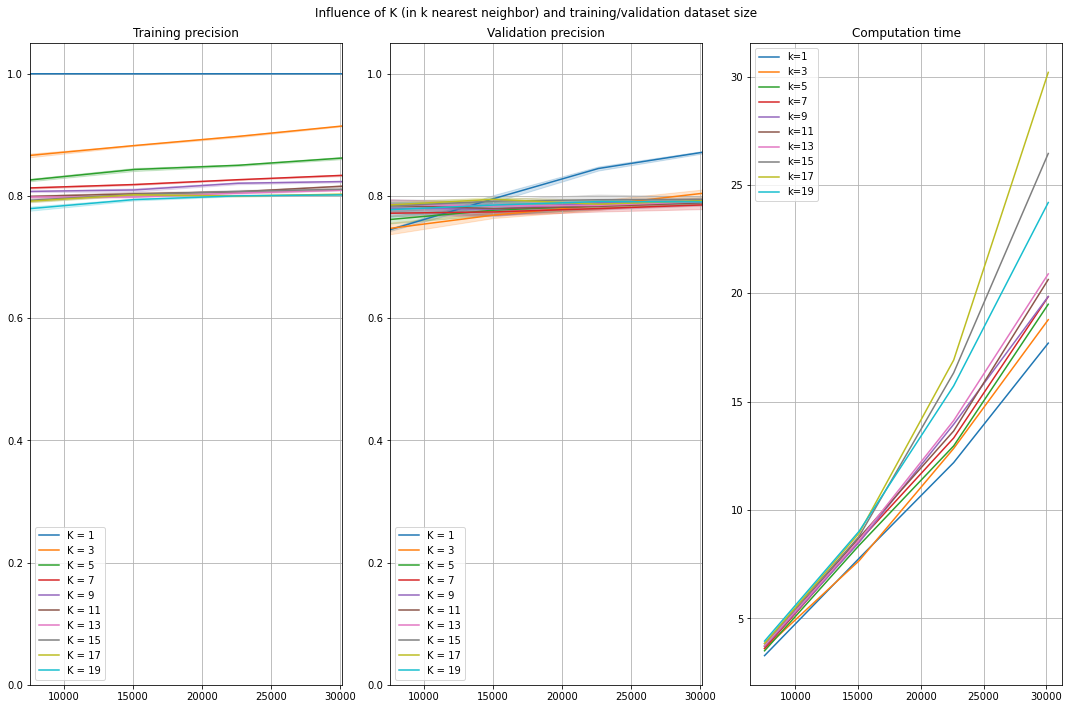

In [29]:
nrows = dataset_adult.shape[0]
Ks = list(range(1, 20, 2))
Ns = [int(k * nrows) for k in [0.25, 0.5, 0.75, 1]]

if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("img/datasize_influence.png"))
else:
    n_neighbors_influence_multiple_datasize(Ks, dataset_adult, labels_adult, Ns, loss_="manhattan",
                                           folds = 5, show_time=True, visualize=True)


Considering the above results, when working on hyperpara

In [30]:
def n_neighbors_influence_fixed_datasize(Ks, dataset_, labels_, N, loss_="manhattan",
                                         weights = "uniform",folds = 5, show_time=False,
                                         visualize=True):
    nrows = dataset_.shape[0]
    mean_trainings = []
    std_trainings = []
    mean_validations = []
    std_validations = []
    
    if show_time: times = []
    
    for k in Ks:
        print(k)
        indices = list(np.random.choice(nrows, N))
        d = dataset_.iloc[indices].reset_index(drop=True)
        l = labels_.iloc[indices].reset_index(drop=True)
        
        if show_time: t = time.time()
        mean_training, std_training, mean_validation, std_validation = cross_validation(knn, d, l, folds = folds, algo_kwargs={"n_neighbors": k, "weights":weights})
        if show_time: times.append(time.time() - t)
        
        mean_trainings.append(mean_training)
        std_trainings.append(std_training)
        mean_validations.append(mean_validation)
        std_validations.append(std_validation)
    
    if visualize:
        fig = plt.figure(figsize=(15,10))
        #fig.suptitle("Influence of training/validation dataset size")
        ax1 = fig.gca()
        plotMeanAndStd([i for i in zip(mean_trainings, std_trainings)], Ks, ax = ax1, color = 'b', legend="Training")
        plotMeanAndStd([i for i in zip(mean_validations, std_validations)], Ks, ax = ax1, color = 'r', legend="Validation")
        ax1.set_ylim(0,1.1)
        ax1.grid()
        ax1.title.set_text("Precision")
        ax1.set_xlabel("K")
        ax1.set_ylabel("Precision")
        ax1.legend()
        ax1.set_xlim(min(Ks), max(Ks))
        if show_time:
            ax5 = fig.add_subplot(235)
            ax5.title.set_text("Computation time")
            ax5.plot(Ks, times)

        plt.show()
    
    if show_time: return (mean_trainings, std_trainings, mean_validations, std_validations, times)
    else: 
        return (mean_trainings, std_trainings, mean_validations, std_validations)
    

### Knn results for dataset 1

First we create a normalized version of the dataset, as well as a version where, after normalization, features are weighted according to the importance a decision tree algorithm gives them. As a trade-off between computation time and precision, we only work with a subset whose size is 75% of the original one.

In [31]:
nrows = dataset_adult.shape[0]
N = int(0.75 * nrows)
indices = list(np.random.choice(nrows, N))
dataset_adult_75 = dataset_adult.iloc[indices].reset_index(drop=True)
labels_adult_75 = labels_adult.iloc[indices].reset_index(drop=True)


normalized_dataset_adult = dataset_adult_75.copy(deep=True)
normalize(normalized_dataset_adult)

normalized_test_dataset_adult = test_dataset_adult.copy(deep=True)
normalize(normalized_test_dataset_adult)

,age,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,fnlwgt,education_10th,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,native-country_Holand-Netherlands
0,-1.029005,-0.178098,-0.271374,0.605378,-0.198698,-0.306982,-0.215272,-0.021564,0.352098,-0.165817,...,-0.066346,-0.024453,-0.044677,-0.029393,-0.028239,-0.023054,0.303734,-0.035542,-0.021564,0.0
1,-0.057423,-0.178098,-0.271374,0.605378,-0.198698,-0.306982,-0.215272,-0.021564,-0.944995,-0.165817,...,-0.066346,-0.024453,-0.044677,-0.029393,-0.028239,-0.023054,0.303734,-0.035542,-0.021564,0.0
2,-0.804794,-0.178098,3.684955,-1.651861,-0.198698,-0.306982,-0.215272,-0.021564,1.395062,-0.165817,...,-0.066346,-0.024453,-0.044677,-0.029393,-0.028239,-0.023054,0.303734,-0.035542,-0.021564,0.0
3,0.391000,-0.178098,-0.271374,0.605378,-0.198698,-0.306982,-0.215272,-0.021564,-0.277369,-0.165817,...,-0.066346,-0.024453,-0.044677,-0.029393,-0.028239,-0.023054,0.303734,-0.035542,-0.021564,0.0
4,-0.356371,-0.178098,-0.271374,0.605378,-0.198698,-0.306982,-0.215272,-0.021564,0.085944,6.030732,...,-0.066346,-0.024453,-0.044677,-0.029393,-0.028239,-0.023054,0.303734,-0.035542,-0.021564,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15055,-0.431108,-0.178098,-0.271374,0.605378,-0.198698,-0.306982,-0.215272,-0.021564,0.526407,-0.165817,...,-0.066346,-0.024453,-0.044677,-0.029393,-0.028239,-0.023054,0.303734,-0.035542,-0.021564,0.0
15056,0.017315,-0.178098,-0.271374,0.605378,-0.198698,-0.306982,-0.215272,-0.021564,0.244316,-0.165817,...,-0.066346,-0.024453,-0.044677,-0.029393,-0.028239,-0.023054,0.303734,-0.035542,-0.021564,0.0
15057,-0.057423,-0.178098,-0.271374,0.605378,-0.198698,-0.306982,-0.215272,-0.021564,1.755175,-0.165817,...,-0.066346,-0.024453,-0.044677,-0.029393,-0.028239,-0.023054,0.303734,-0.035542,-0.021564,0.0
15058,0.391000,-0.178098,-0.271374,0.605378,-0.198698,-0.306982,-0.215272,-0.021564,-1.001078,-0.165817,...,-0.066346,-0.024453,-0.044677,-0.029393,-0.028239,-0.023054,0.303734,-0.035542,-0.021564,0.0


In [32]:
normalized_dataset_adult

,age,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,fnlwgt,education_10th,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0.860482,-0.180272,-0.274028,0.592445,-0.192834,-0.296856,-0.207642,-0.017594,-1.110448,-0.164783,...,-0.033922,-0.059199,-0.02103,-0.047066,-0.031201,-0.026605,-0.016288,0.308001,-0.050261,-0.01995
1,0.860482,-0.180272,-0.274028,0.592445,-0.192834,-0.296856,-0.207642,-0.017594,-0.290695,-0.164783,...,-0.033922,-0.059199,-0.02103,-0.047066,-0.031201,-0.026605,-0.016288,0.308001,-0.050261,-0.01995
2,2.072855,-0.180272,3.649259,-1.687920,-0.192834,-0.296856,-0.207642,-0.017594,1.777709,-0.164783,...,-0.033922,-0.059199,-0.02103,-0.047066,-0.031201,-0.026605,-0.016288,0.308001,-0.050261,-0.01995
3,0.026975,-0.180272,-0.274028,-1.687920,5.185820,-0.296856,-0.207642,-0.017594,-0.011627,-0.164783,...,-0.033922,-0.059199,-0.02103,-0.047066,-0.031201,-0.026605,-0.016288,0.308001,-0.050261,-0.01995
4,0.633162,-0.180272,3.649259,-1.687920,-0.192834,-0.296856,-0.207642,-0.017594,0.930828,-0.164783,...,-0.033922,-0.059199,-0.02103,-0.047066,-0.031201,-0.026605,-0.016288,0.308001,-0.050261,-0.01995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22616,0.178522,-0.180272,-0.274028,0.592445,-0.192834,-0.296856,-0.207642,-0.017594,-0.092236,-0.164783,...,-0.033922,-0.059199,-0.02103,-0.047066,-0.031201,-0.026605,-0.016288,0.308001,-0.050261,-0.01995
22617,-0.351892,-0.180272,-0.274028,0.592445,-0.192834,-0.296856,-0.207642,-0.017594,-0.533386,-0.164783,...,-0.033922,-0.059199,-0.02103,-0.047066,-0.031201,-0.026605,-0.016288,0.308001,-0.050261,-0.01995
22618,-0.276118,-0.180272,3.649259,-1.687920,-0.192834,-0.296856,-0.207642,-0.017594,4.548670,-0.164783,...,-0.033922,-0.059199,-0.02103,-0.047066,-0.031201,-0.026605,-0.016288,0.308001,-0.050261,-0.01995
22619,-0.579212,-0.180272,-0.274028,0.592445,-0.192834,-0.296856,-0.207642,-0.017594,0.797927,-0.164783,...,-0.033922,-0.059199,-0.02103,-0.047066,-0.031201,-0.026605,-0.016288,0.308001,-0.050261,-0.01995


In [33]:
labels_adult_75

0        0
1        1
2        0
3        1
4        0
        ..
22616    1
22617    0
22618    0
22619    0
22620    0
Name: salary, Length: 22621, dtype: int32

In [34]:
weighted_dataset_adult = normalized_dataset_adult.copy(deep=True)
weights = features_importance(normalized_dataset_adult, labels_adult_75, criterion='gini', splitter='best')
weight_features(weighted_dataset_adult, weights)


weighted_test_dataset_adult = normalized_test_dataset_adult.copy(deep=True)
weight_features(weighted_test_dataset_adult, weights)


#### Selecting best hyperparameter

###### Uniform weights, no normalization

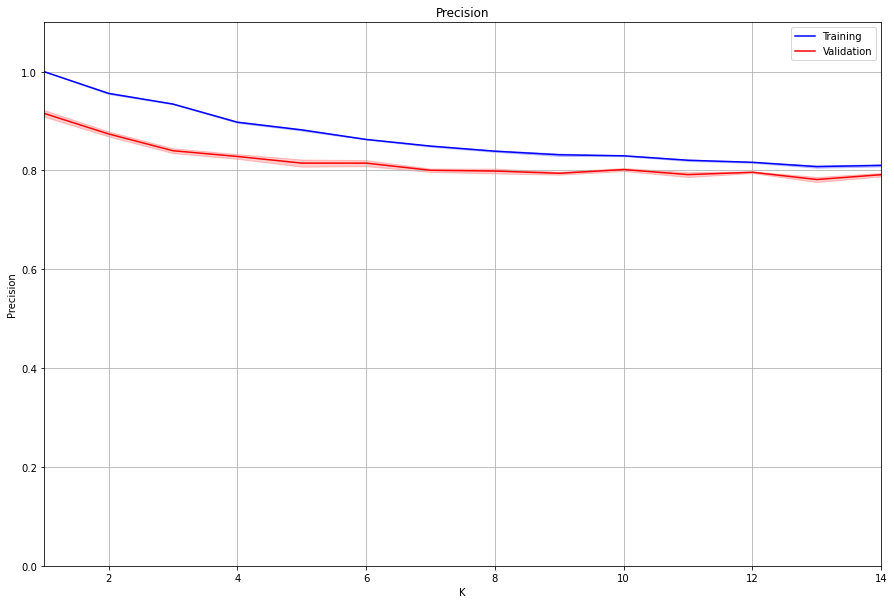

In [35]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/1.png"))
else:
    (mean_trainings, std_trainings, mean_validations, std_validations) = n_neighbors_influence_fixed_datasize(list(range(1, 15)), dataset_adult_75, labels_adult_75, N, loss_="manhattan",
                                         weights="uniform", folds = 5, show_time=False, visualize=True)
    print(f"Best result is {max(mean_validations)} for k = {mean_validations.index(max(mean_validations)) + 1}")

Considering the above results, we choose to use the hyperparameter k =.

###### Uniform weights, normalization

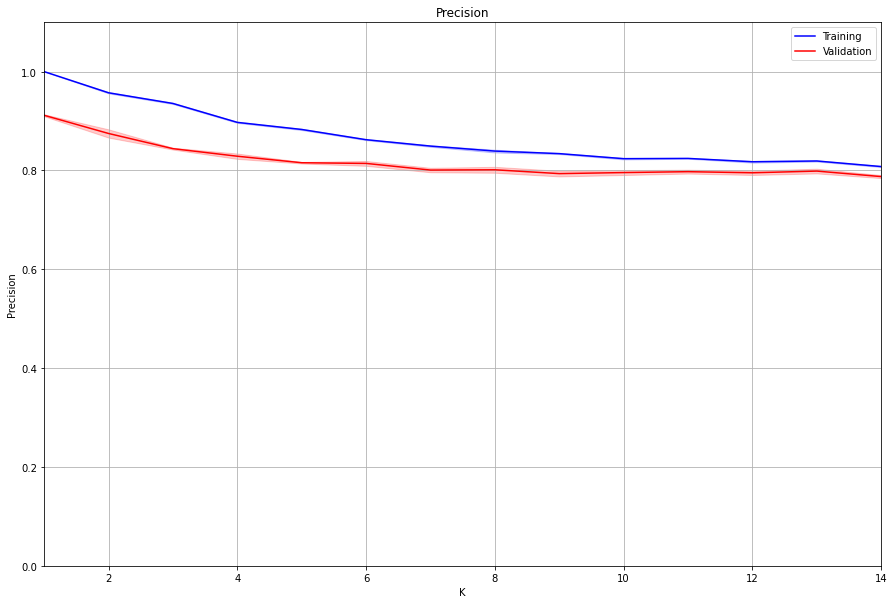

In [36]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/2.png"))
else:
    (mean_trainings, std_trainings, mean_validations, std_validations) = n_neighbors_influence_fixed_datasize(list(range(1, 15)), dataset_adult_75, labels_adult_75, N, loss_="manhattan",
                                         weights="uniform", folds = 5, show_time=False, visualize=True)
    print(f"Best result is {max(mean_validations)} for k = {mean_validations.index(max(mean_validations)) + 1}")

Considering the above results, we choose to use the hyperparameter k =.

###### Uniform weights, normalization and weighted features

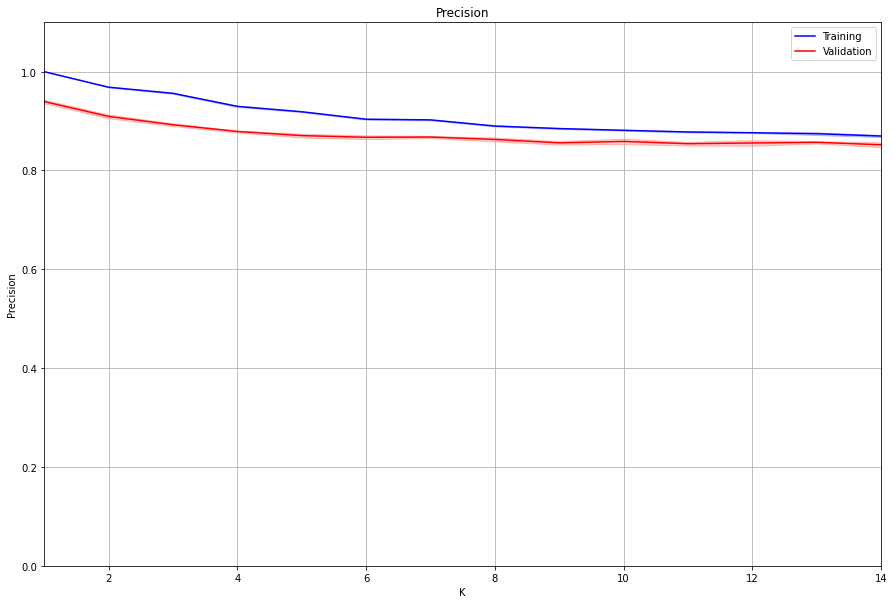

In [37]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/3.png"))
else:
    (mean_trainings, std_trainings, mean_validations, std_validations) =n_neighbors_influence_fixed_datasize(list(range(1, 15)), weighted_dataset_adult, labels_adult_75, N, loss_="manhattan",
                                         weights="uniform", folds = 5, show_time=False, visualize=True)

    print(f"Best result is {max(mean_validations)} for k = {mean_validations.index(max(mean_validations)) + 1}")

Considering the above results, we choose to use the hyperparameter k =.

###### Distance weights, no normalization 

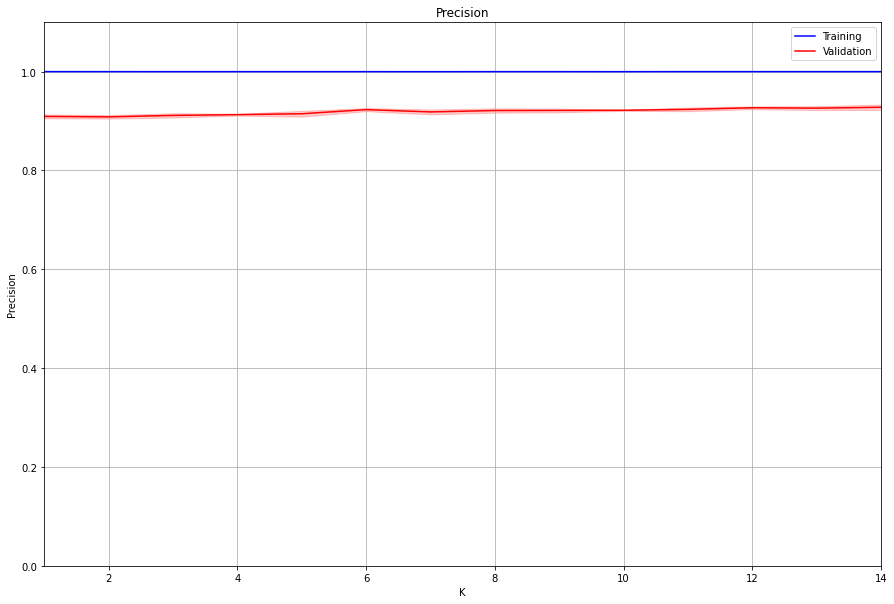

In [38]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/4.png"))
else:

    (mean_trainings, std_trainings, mean_validations, std_validations) =n_neighbors_influence_fixed_datasize(list(range(1, 15)), dataset_adult_75, labels_adult_75, N, loss_="manhattan",
                                         weights="distance", folds = 5, show_time=False, visualize=True)
    print(f"Best result is {max(mean_validations)} for k = {mean_validations.index(max(mean_validations)) + 1}")

Considering the above results, we choose to use the hyperparameter k =.

###### Distance weights, normalization 

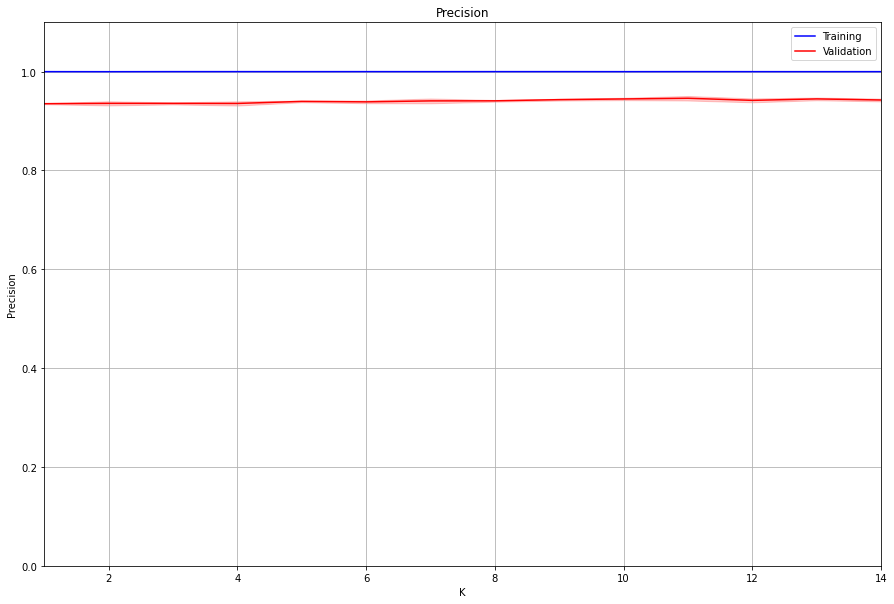

In [39]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/5.png"))
else:

    (mean_trainings, std_trainings, mean_validations, std_validations) =n_neighbors_influence_fixed_datasize(list(range(1, 15)), normalized_dataset_adult, labels_adult_75, N, loss_="manhattan",
                                         weights="distance", folds = 5, show_time=False, visualize=True)
    print(f"Best result is {max(mean_validations)} for k = {mean_validations.index(max(mean_validations)) + 1}")

Considering the above results, we choose to use the hyperparameter k =.

###### Distance weights, normalization and weighted features

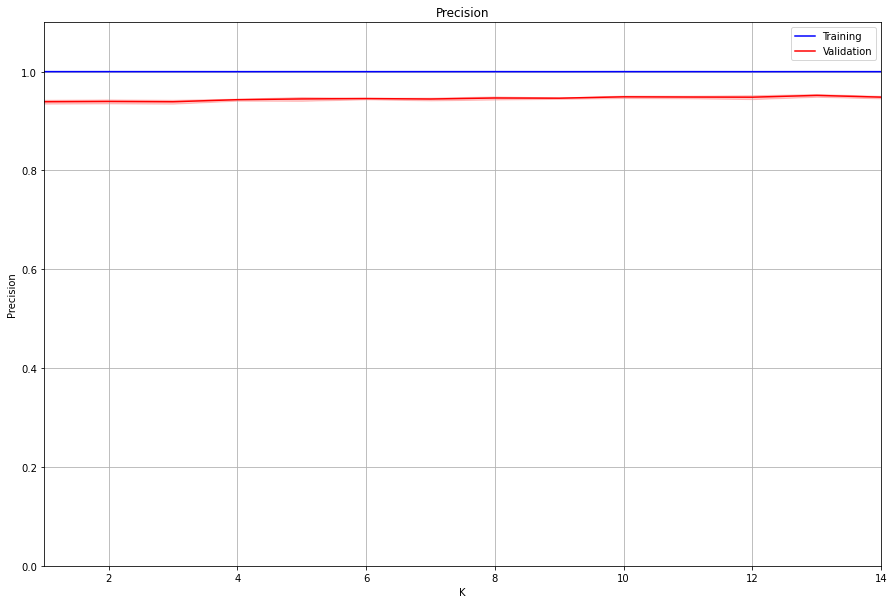

In [40]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/6.png"))
else:
    (mean_trainings, std_trainings, mean_validations, std_validations) =n_neighbors_influence_fixed_datasize(list(range(1, 15)), weighted_dataset_adult, labels_adult_75, N, loss_="manhattan",
                                         weights="distance", folds = 5, show_time=False, visualize=True)
    print(f"Best result is {max(mean_validations)} for k = {mean_validations.index(max(mean_validations)) + 1}")

Considering the above results, we choose to use the hyperparameter k =.

#### Results on test dataset

##### Uniform weights, no normalization

In [41]:
k1 = 1

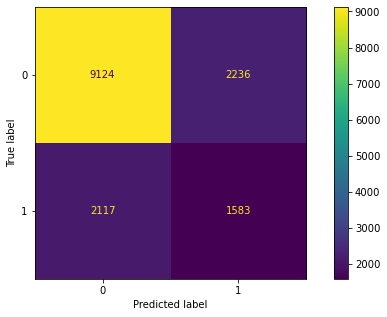

In [42]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/r1.png"))
else:
    predicted_labels1 = knn(dataset_adult_75, labels_adult_75, test_dataset_adult, n_neighbors=k1, weights = "uniform", algorithm="auto", p=2)
    precision1 = (len(test_labels_adult) - error(predicted_labels1, test_labels_adult))/len(test_labels_adult)
    print(f"Precision on the test dataset is {precision1}")
    disp = ConfusionMatrixDisplay(confusion_matrix(test_labels_adult, predicted_labels1))
    disp.plot()

##### Uniform weights, normalization

In [43]:
k2 = 1

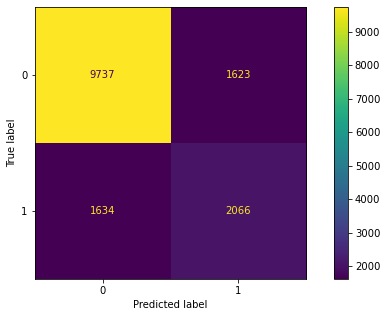

In [44]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/r2.png"))
else:
    predicted_labels2 = knn(normalized_dataset_adult, labels_adult_75, normalized_test_dataset_adult, n_neighbors=k2, weights = "uniform", algorithm="auto", p=2)
    precision2 = (len(test_labels_adult) - error(predicted_labels2, test_labels_adult))/len(test_labels_adult)
    print(f"Precision on the test dataset is {precision2}")
    disp = ConfusionMatrixDisplay(confusion_matrix(test_labels_adult, predicted_labels2))
    disp.plot()

##### Uniform weights, normalization and weighted features

In [45]:
k3 = 1

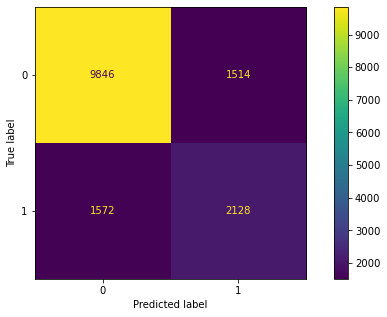

In [46]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/r3.png"))
else:
    predicted_labels3 = knn(weighted_dataset_adult, labels_adult_75, weighted_test_dataset_adult, n_neighbors=k3, weights = "uniform", algorithm="auto", p=2)
    precision3 = (len(test_labels_adult) - error(predicted_labels3, test_labels_adult))/len(test_labels_adult)
    print(f"Precision on the test dataset is {precision3}")
    disp = ConfusionMatrixDisplay(confusion_matrix(test_labels_adult, predicted_labels3))
    disp.plot()

##### Distance weights, no normalization

In [47]:
k4 = 14

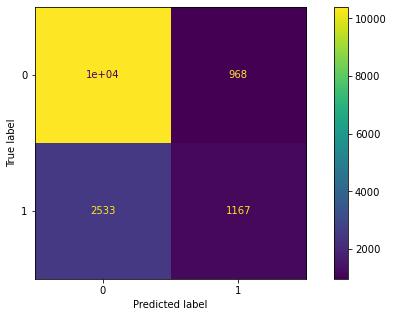

In [48]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/r4.png"))
else:
    predicted_labels4 = knn(dataset_adult_75, labels_adult_75, test_dataset_adult, n_neighbors=k4, weights = "distance", algorithm="auto", p=2)
    precision4 = (len(test_labels_adult) - error(predicted_labels4, test_labels_adult))/len(test_labels_adult)
    print(f"Precision on the test dataset is {precision4}")
    disp = ConfusionMatrixDisplay(confusion_matrix(test_labels_adult, predicted_labels4))
    disp.plot()

##### Distance weights,  normalization

In [49]:
k5 = 11

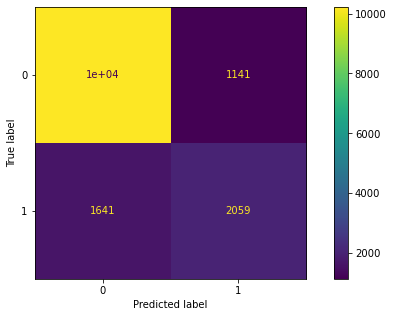

In [50]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/r5.png"))
else:
    predicted_labels5 = knn(normalized_dataset_adult, labels_adult_75, normalized_test_dataset_adult, n_neighbors=k5, weights = "distance", algorithm="auto", p=2)
    precision5 = (len(test_labels_adult) - error(predicted_labels5, test_labels_adult))/len(test_labels_adult)
    print(f"Precision on the test dataset is {precision5}")
    disp = ConfusionMatrixDisplay(confusion_matrix(test_labels_adult, predicted_labels5))
    disp.plot()

##### Distance weights,  normalization and weighted features

In [51]:
k6 = 13

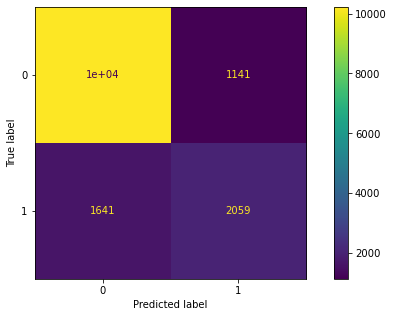

In [52]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/r6.png"))
else:
    predicted_labels6 = knn(weighted_dataset_adult, labels_adult_75, weighted_test_dataset_adult, n_neighbors=k6, weights = "distance", algorithm="auto", p=2)
    precision6 = (len(test_labels_adult) - error(predicted_labels6, test_labels_adult))/len(test_labels_adult)
    print(f"Precision on the test dataset is {precision6}")
    disp = ConfusionMatrixDisplay(confusion_matrix(test_labels_adult, predicted_labels5))
    disp.plot()

### Knn results for dataset 2

First we create a normalized version of the dataset, as well as a version where, after normalization, features are weighted according to the importance a decision tree algorithm gives them.

In [53]:
normalized_dataset_chess = dataset_chess.copy(deep=True)
normalize(normalized_dataset_chess)

normalized_test_dataset_chess = test_dataset_chess.copy(deep=True)
normalize(normalized_test_dataset_chess)

,white_king_column,white_king_row,white_rook_column,white_rook_row,black_king_column,black_king_row
0,-1.182655,0.176771,-0.222213,-1.528230,0.855739,1.143201
1,-0.114192,0.176771,-1.519492,0.662074,-0.013142,0.695370
2,0.954271,-0.911886,-0.222213,-1.090169,0.421299,-0.200293
3,0.954271,0.176771,1.507492,-1.528230,-1.750904,-1.095955
4,-0.114192,-0.911886,0.642640,0.224013,0.855739,-1.543786
...,...,...,...,...,...,...
7995,0.954271,1.265427,1.075066,1.538196,0.421299,-1.095955
7996,-0.114192,-0.911886,1.075066,-0.214047,0.855739,-1.543786
7997,-1.182655,-0.911886,-1.519492,-1.090169,0.855739,0.247539
7998,-0.114192,0.176771,0.642640,-0.652108,-0.013142,-0.200293


In [54]:
weighted_dataset_chess = normalized_dataset_chess.copy(deep=True)
weights = features_importance(normalized_dataset_chess, labels_chess, criterion='gini', splitter='best')
weight_features(weighted_dataset_chess, weights)


weighted_test_dataset_chess = normalized_test_dataset_chess.copy(deep=True)
weight_features(weighted_test_dataset_chess, weights)


#### Selecting best hyperparameter

##### Uniform weights, no normalization

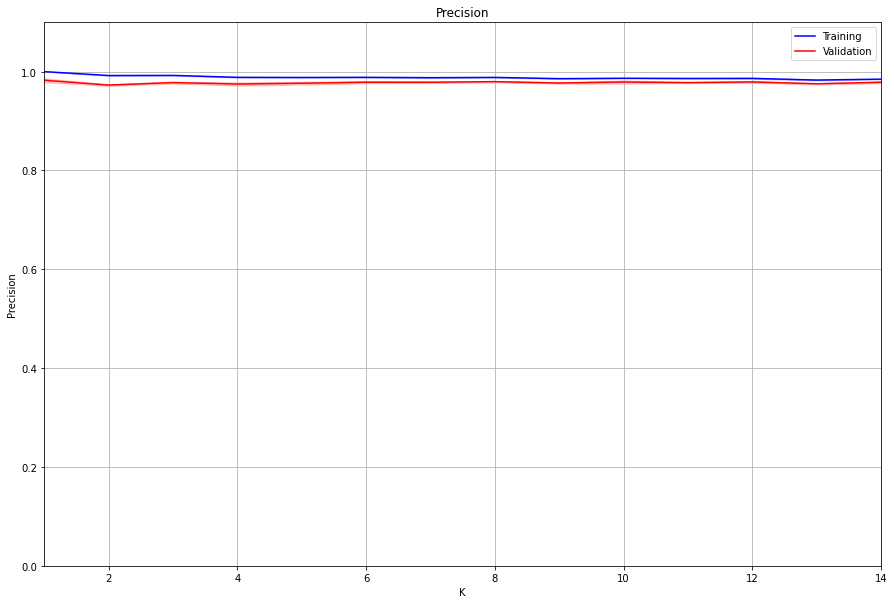

In [55]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/d2_1.png"))
else:
    (mean_trainings, std_trainings, mean_validations, std_validations) =n_neighbors_influence_fixed_datasize(list(range(1, 15)), dataset_chess, labels_chess, nrows, loss_="manhattan",
                                         weights="uniform", folds = 5, show_time=False, visualize=True)

Considering the above results, we choose to use the hyperparameter k = 1.

##### Uniform weights, normalization

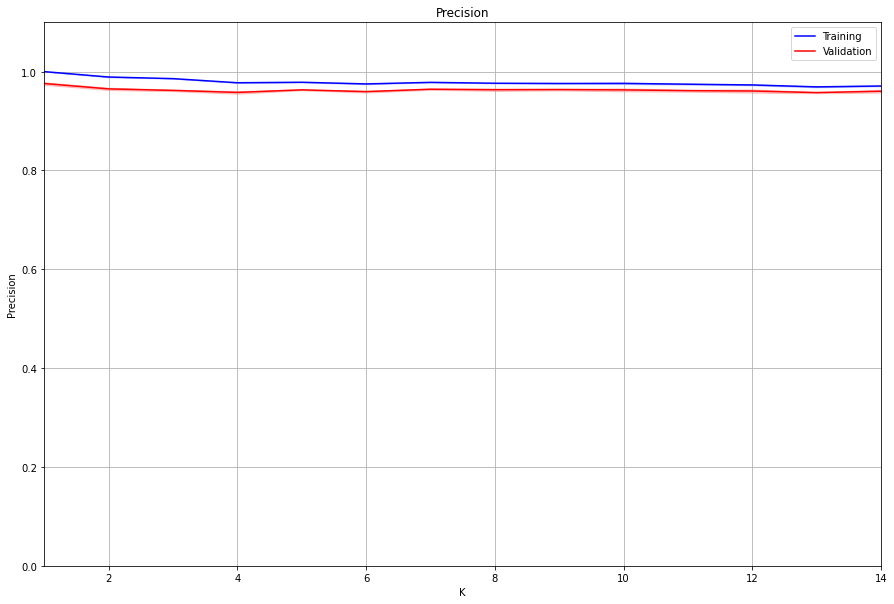

In [56]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/d2_2.png"))
else:
    (mean_trainings, std_trainings, mean_validations, std_validations) =n_neighbors_influence_fixed_datasize(list(range(1, 15)), normalized_dataset_chess, labels_chess, nrows, loss_="manhattan",
                                         weights="uniform", folds = 5, show_time=False, visualize=True)

Considering the above results, we choose to use the hyperparameter k = 1.

##### Uniform weights,  normalization and weighted features

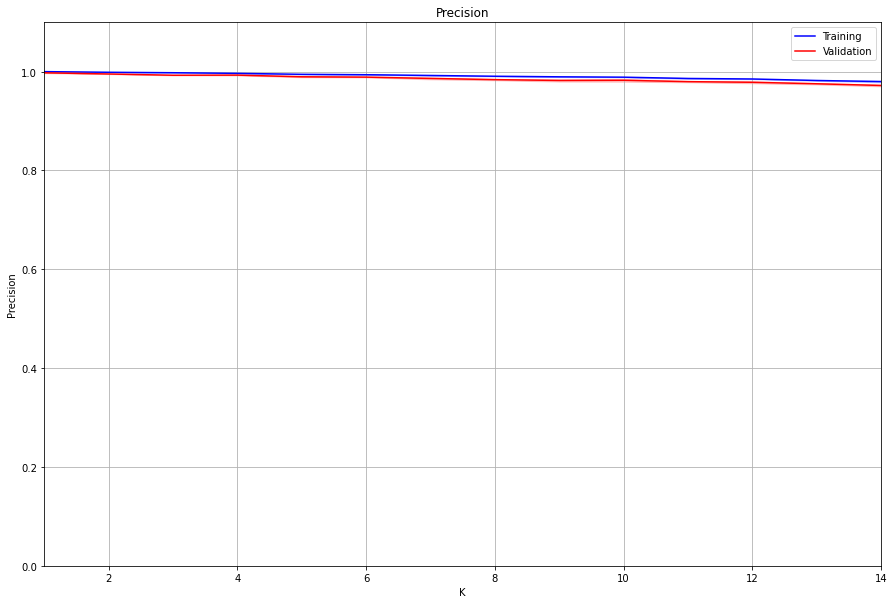

In [57]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/d2_3.png"))
else:
    (mean_trainings, std_trainings, mean_validations, std_validations) =n_neighbors_influence_fixed_datasize(list(range(1, 15)), weighted_dataset_chess, labels_chess, nrows, loss_="manhattan",
                                         weights="uniform", folds = 5, show_time=False, visualize=True)

Considering the above results, we choose to use the hyperparameter k = 1.

##### Distance weights, no normalization

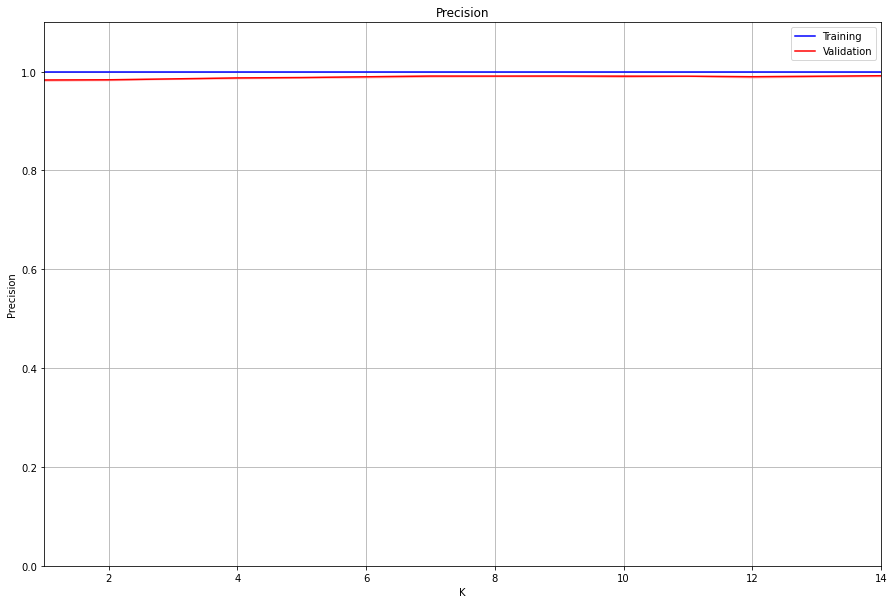

In [58]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/d2_4.png"))
else:
    (mean_trainings, std_trainings, mean_validations, std_validations) =n_neighbors_influence_fixed_datasize(list(range(1, 15)), dataset_chess, labels_chess, nrows, loss_="manhattan",
                                         weights="distance", folds = 5, show_time=False, visualize=True)

Considering the above results, we choose to use the hyperparameter k = 8.

##### Distance weights, normalization

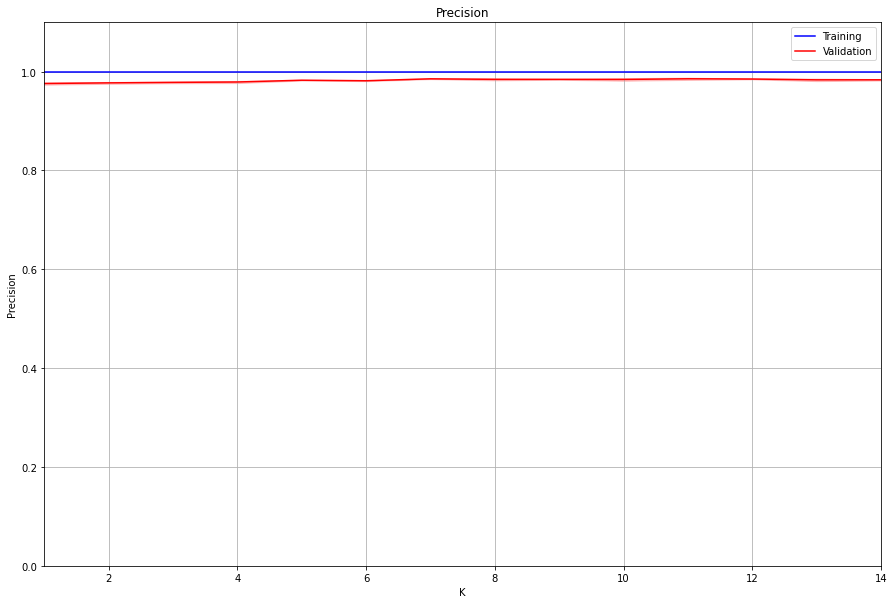

In [59]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/d2_5.png"))
else:
    (mean_trainings, std_trainings, mean_validations, std_validations) =n_neighbors_influence_fixed_datasize(list(range(1, 15)), normalized_dataset_chess, labels_chess, nrows, loss_="manhattan",
                                         weights="distance", folds = 5, show_time=False, visualize=True)

Considering the above results, we choose to use the hyperparameter k = 8.

##### Distance weights, normalization and weighted features

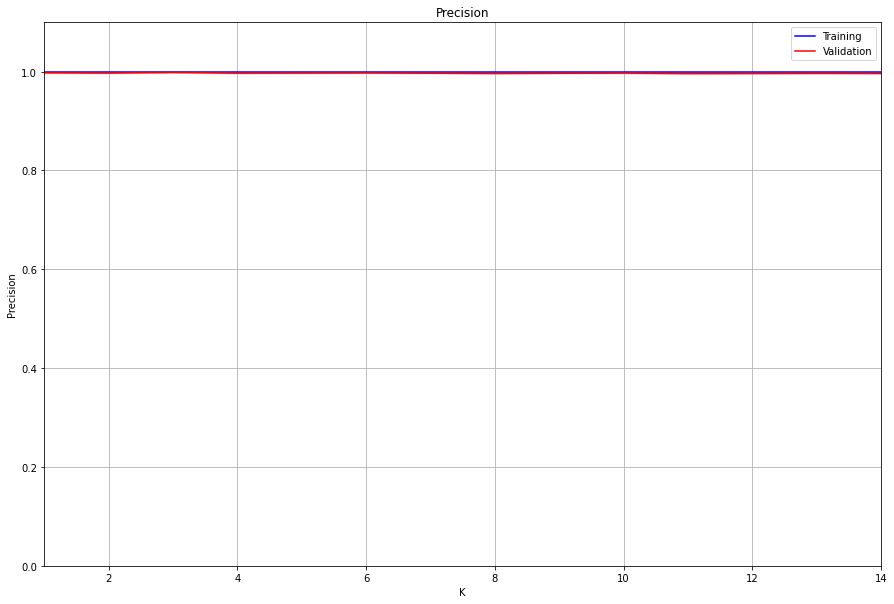

In [60]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/d2_6.png"))
else:
    (mean_trainings, std_trainings, mean_validations, std_validations) =n_neighbors_influence_fixed_datasize(list(range(1, 15)), weighted_dataset_chess, labels_chess, nrows, loss_="manhattan",
                                         weights="distance", folds = 5, show_time=False, visualize=True)

Considering the above results, we choose to use the hyperparameter k = 1.

In [61]:
# TO DO : plot the performance depending on K for the entire dataset, choose simplest best K

#### Results on test dataset

##### Uniform weights, no normalization

In [62]:
k1 = 1

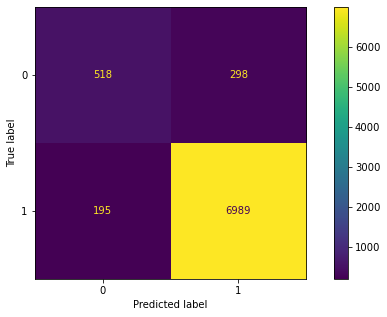

In [63]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/d2_r1.png"))
else:
    predicted_labels1 = knn(dataset_chess, labels_chess, test_dataset_chess, n_neighbors=k1, weights = "uniform", algorithm="auto", p=2)
    precision1 = (len(test_labels_chess) - error(predicted_labels1, test_labels_chess))/len(test_labels_chess)
    print(f"Precision on the test dataset is {precision1}")
    disp = ConfusionMatrixDisplay(confusion_matrix(test_labels_chess, predicted_labels1))
    disp.plot()

##### Uniform weights, normalization

In [64]:
k2 = 1

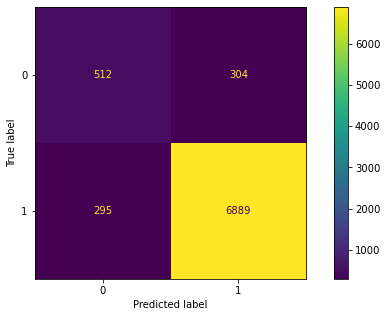

In [65]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/d2_r2.png"))
else:
    predicted_labels2 = knn(normalized_dataset_chess, labels_chess, normalized_test_dataset_chess, n_neighbors=k2, weights = "uniform", algorithm="auto", p=2)
    precision2 = (len(test_labels_chess) - error(predicted_labels2, test_labels_chess))/len(test_labels_chess)
    print(f"Precision on the test dataset is {precision2}")
    disp = ConfusionMatrixDisplay(confusion_matrix(test_labels_chess, predicted_labels2))
    disp.plot()

##### Uniform weights, normalization and weighted features

In [66]:
k3 = 1

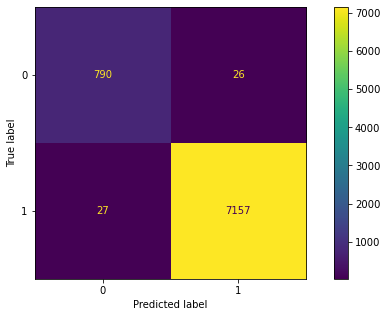

In [67]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/d2_r3.png"))
else:
    predicted_labels3 = knn(weighted_dataset_chess, labels_chess, weighted_test_dataset_chess, n_neighbors=k3, weights = "uniform", algorithm="auto", p=2)
    precision3 = (len(test_labels_chess) - error(predicted_labels3, test_labels_chess))/len(test_labels_chess)
    print(f"Precision on the test dataset is {precision3}")
    disp = ConfusionMatrixDisplay(confusion_matrix(test_labels_chess, predicted_labels3))
    disp.plot()

##### Distance weights, no normalization

In [68]:
k4 = 8

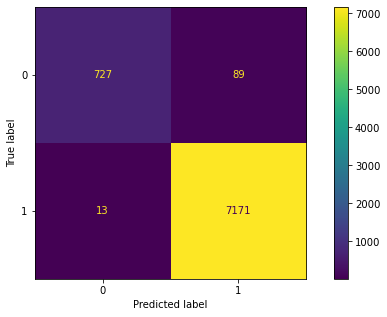

In [69]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/d2_r4.png"))
else:
    predicted_labels4 = knn(dataset_chess, labels_chess, test_dataset_chess, n_neighbors=k4, weights = "distance", algorithm="auto", p=2)
    precision4 = (len(test_labels_chess) - error(predicted_labels4, test_labels_chess))/len(test_labels_chess)
    print(f"Precision on the test dataset is {precision4}")
    disp = ConfusionMatrixDisplay(confusion_matrix(test_labels_chess, predicted_labels4))
    disp.plot()

##### Distance weights,  normalization

In [70]:
k5 = 8

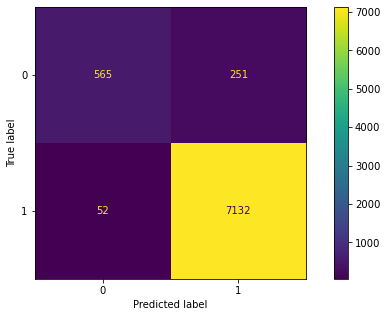

In [71]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/d2_r5.png"))
else:
    predicted_labels5 = knn(normalized_dataset_chess, labels_chess, normalized_test_dataset_chess, n_neighbors=k5, weights = "distance", algorithm="auto", p=2)
    precision5 = (len(test_labels_chess) - error(predicted_labels5, test_labels_chess))/len(test_labels_chess)
    print(f"Precision on the test dataset is {precision5}")
    disp = ConfusionMatrixDisplay(confusion_matrix(test_labels_chess, predicted_labels5))
    disp.plot()

##### Distance weights,  normalization and weighted features

In [72]:
k6 = 1

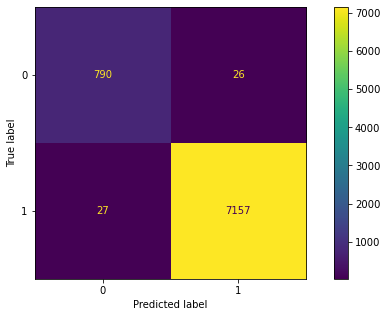

In [73]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/d2_r6.png"))
else:
    predicted_labels6 = knn(weighted_dataset_chess, labels_chess, weighted_test_dataset_chess, n_neighbors=k6, weights = "distance", algorithm="auto", p=2)
    precision6 = (len(test_labels_chess) - error(predicted_labels6, test_labels_chess))/len(test_labels_chess)
    print(f"Precision on the test dataset is {precision6}")
    disp = ConfusionMatrixDisplay(confusion_matrix(test_labels_chess, predicted_labels6))
    disp.plot()

# Decision tree

### Decision Tree algorithm implementation

We use scikit-learn's decision tree function to design a decision tree classifier.

In [74]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

In [75]:
def decision_tree(training_features, training_labels, to_predict_features, max_depth=None, criterion='gini'):
    """
    :param training_features: training features (x)
    :param training_labels: training labels (y)
    :param to_predict_features: features that we want to predict
    :param max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure.
    :param criterion: {"gini", "entropy"} Default is "gini" for the Gini impurity and "entropy" for the information gain
    :return:Numpy array containing the labels predicted by Decision Tree for the given 'to_predict_features'
    """
    classifier = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion)
    classifier.fit(training_features, training_labels)
    
    return classifier.predict(to_predict_features)

### Let us study the influence of the hyperparameter max_depth

Let us study the influence of the hyperparameter max_depth on decision tree algorithm's performance.

In [76]:
def decision_tree_influence_multiple_datasize(max_depths, dataset_, labels_, Ns, criterion = "gini", loss_="manhattan",
                                            folds = 5, show_time=False, visualize=True):
    
    mean_training_per_depth = dict()
    std_training_per_depth = dict()
    mean_validation_per_depth = dict()
    std_validation_per_depth = dict()
    
    if show_time: time_per_depth = dict()
    
    for depth in max_depths:
        print(depth)
        if show_time: (mean_trainings, std_trainings, mean_validations, std_validations, times) = data_size_influence(decision_tree, dataset_, labels_, Ns, loss_="manhattan", folds = folds, algo_kwargs={"max_depth":depth, "criterion":criterion}, show_time=show_time, visualize=False)
        else: (mean_trainings, std_trainings, mean_validations, std_validations) = data_size_influence(decision_tree, dataset_, labels_, Ns, loss_="manhattan", folds = folds, algo_kwargs={"max_depth":depth, "criterion":criterion}, show_time=show_time, visualize=False)
            
        mean_training_per_depth[depth] = mean_trainings
        std_training_per_depth[depth] = std_trainings
        mean_validation_per_depth[depth]  = mean_validations
        std_validation_per_depth[depth]  = std_validations

        if show_time: time_per_depth[depth]  = times
    subplotcode = 120
    if show_time :
        subplotcode = 130
    if visualize:
        
        fig = plt.figure(figsize=(15,10))
        fig.suptitle("Influence of max depth (in decision tree) and training/validation dataset size")
        
        ax1 = fig.add_subplot(subplotcode+1)
        ax1.title.set_text("Training precision")
        cmap = plt.get_cmap("tab10")
        curveID = 0
        for depth in max_depths:
            plotMeanAndStd([i for i in zip(mean_training_per_depth[depth],std_training_per_depth[depth])],Ns, legend="depth = "+str(depth),ax = ax1, color = cmap(curveID))
            curveID += 1
        ax1.set_ylim(0,1.05)
        ax1.set_xlim(Ns[0],Ns[-1])
        ax1.grid()
        ax1.legend()
        
        ax2 = fig.add_subplot(subplotcode+2)
        curveID = 0
        for depth in max_depths:
            plotMeanAndStd([i for i in zip(mean_validation_per_depth[depth],std_validation_per_depth[depth])],Ns, legend="depth = "+str(depth), ax=ax2,color = cmap(curveID))
            curveID += 1
        ax2.set_ylim(0,1.05)
        ax2.title.set_text("Validation precision")
        ax2.set_xlim(Ns[0],Ns[-1])
        ax2.grid()
        ax2.legend()
        
        if show_time:
            ax5 = fig.add_subplot(subplotcode+3)
            ax5.title.set_text("Computation time")
            for depth in max_depths:
                ax5.plot(Ns, time_per_depth[depth], label=f"depth={depth}")
            ax5.grid()
            plt.legend()
        


        fig.tight_layout()
              
        plt.show()
    
    if show_time: return (mean_training_per_depth, std_training_per_depth, mean_validation_per_depth, std_validation_per_depth, time_per_depth)
    else: return (mean_training_per_depth, std_training_per_depth, mean_validation_per_depth, std_validation_per_depth)
    

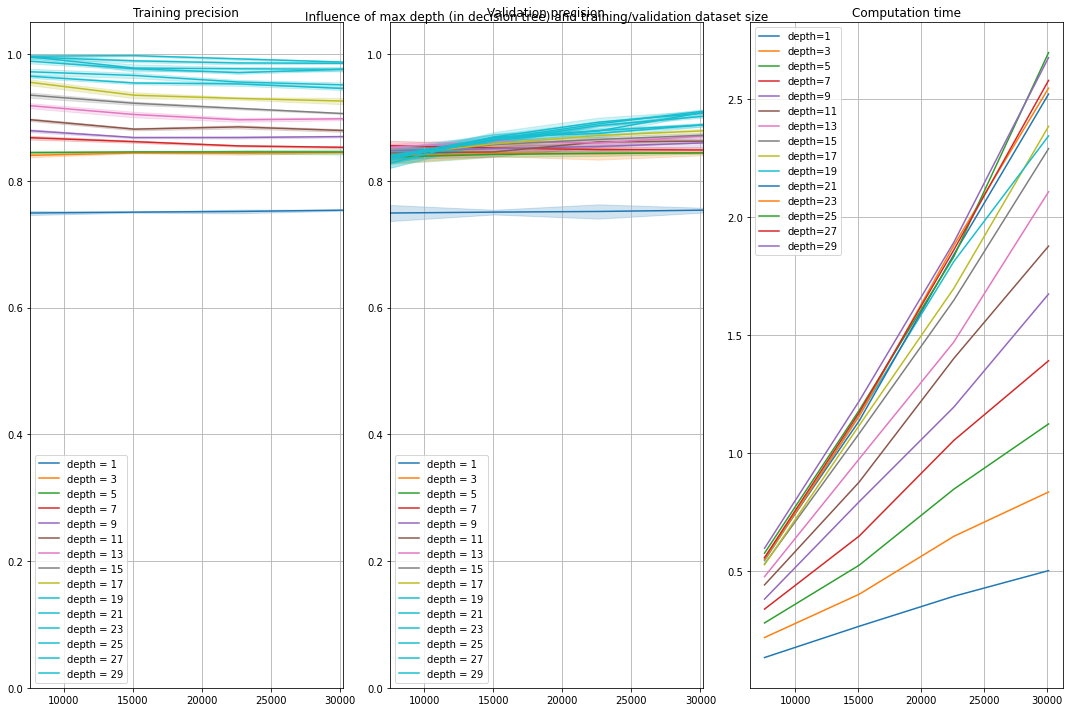

In [77]:
nrows = dataset_adult.shape[0]
max_depths = list(range(1, 30, 2))
Ns = [int(index * nrows) for index in [0.25, 0.5, 0.75, 1]]

if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("img/decision_tree_dataset_size_influence.png"))
else: 
    decision_tree_influence_multiple_datasize(max_depths, dataset_adult, labels_adult, Ns, criterion="gini", loss_="manhattan",
                                              folds = 5, show_time=True, visualize=True)


In [78]:
def decision_tree_influence_fixed_datasize(max_depths, dataset_, labels_, N, loss_="manhattan", criterion='gini', 
                                         folds = 5, show_time=False, visualize=True):
    nrows = dataset_.shape[0]
    mean_trainings = []
    std_trainings = []
    mean_validations = []
    std_validations = []
    
    if show_time: times = []
    
    for depth in max_depths:
        indices = list(np.random.choice(nrows, N))
        d = dataset_.iloc[indices].reset_index(drop=True)
        l = labels_.iloc[indices].reset_index(drop=True)
        
        if show_time: t = time.time()
        mean_training, std_training, mean_validation, std_validation = cross_validation(decision_tree, d, l, folds = folds, algo_kwargs={"max_depth": depth, "criterion": criterion})
        if show_time: times.append(time.time() - t)
        
        mean_trainings.append(mean_training)
        std_trainings.append(std_training)
        mean_validations.append(mean_validation)
        std_validations.append(std_validation)

    if visualize:
        fig = plt.figure(figsize=(15,10))
        #fig.suptitle("Influence of training/validation dataset size")
        ax1 = fig.gca()
        plotMeanAndStd([i for i in zip(mean_trainings, std_trainings)], max_depths, ax = ax1, color = 'b', legend="Training")
        plotMeanAndStd([i for i in zip(mean_validations, std_validations)], max_depths, ax = ax1, color = 'r', legend="Validation")
        ax1.set_ylim(0,1.1)
        ax1.grid()
        ax1.title.set_text("Precision")
        ax1.set_xlabel("max depth")
        ax1.set_ylabel("Precision")
        ax1.legend()
        ax1.set_xlim(min(max_depths), max(max_depths))
        if show_time:
            ax5 = fig.add_subplot(235)
            ax5.title.set_text("Computation time")
            ax5.plot(max_depths, times)

        plt.show()
    
    if show_time: return (mean_trainings, std_trainings, mean_validations, std_validations, times)
    else: 
        return (mean_trainings, std_trainings, mean_validations, std_validations)

### Decision tree results for dataset 1

Define dataset_adult_75 and weighted_dataset_adult (same as above)

In [79]:
nrows = dataset_adult.shape[0]
N = int(0.75 * nrows)
indices = list(np.random.choice(nrows, N))
dataset_adult_75 = dataset_adult.iloc[indices].reset_index(drop=True)
labels_adult_75 = labels_adult.iloc[indices].reset_index(drop=True)


normalized_dataset_adult = dataset_adult_75.copy(deep=True)
normalize(normalized_dataset_adult)

normalized_test_dataset_adult = test_dataset_adult.copy(deep=True)
normalize(normalized_test_dataset_adult)

,age,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,fnlwgt,education_10th,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,native-country_Holand-Netherlands
0,-1.029005,-0.178098,-0.271374,0.605378,-0.198698,-0.306982,-0.215272,-0.021564,0.352098,-0.165817,...,-0.066346,-0.024453,-0.044677,-0.029393,-0.028239,-0.023054,0.303734,-0.035542,-0.021564,0.0
1,-0.057423,-0.178098,-0.271374,0.605378,-0.198698,-0.306982,-0.215272,-0.021564,-0.944995,-0.165817,...,-0.066346,-0.024453,-0.044677,-0.029393,-0.028239,-0.023054,0.303734,-0.035542,-0.021564,0.0
2,-0.804794,-0.178098,3.684955,-1.651861,-0.198698,-0.306982,-0.215272,-0.021564,1.395062,-0.165817,...,-0.066346,-0.024453,-0.044677,-0.029393,-0.028239,-0.023054,0.303734,-0.035542,-0.021564,0.0
3,0.391000,-0.178098,-0.271374,0.605378,-0.198698,-0.306982,-0.215272,-0.021564,-0.277369,-0.165817,...,-0.066346,-0.024453,-0.044677,-0.029393,-0.028239,-0.023054,0.303734,-0.035542,-0.021564,0.0
4,-0.356371,-0.178098,-0.271374,0.605378,-0.198698,-0.306982,-0.215272,-0.021564,0.085944,6.030732,...,-0.066346,-0.024453,-0.044677,-0.029393,-0.028239,-0.023054,0.303734,-0.035542,-0.021564,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15055,-0.431108,-0.178098,-0.271374,0.605378,-0.198698,-0.306982,-0.215272,-0.021564,0.526407,-0.165817,...,-0.066346,-0.024453,-0.044677,-0.029393,-0.028239,-0.023054,0.303734,-0.035542,-0.021564,0.0
15056,0.017315,-0.178098,-0.271374,0.605378,-0.198698,-0.306982,-0.215272,-0.021564,0.244316,-0.165817,...,-0.066346,-0.024453,-0.044677,-0.029393,-0.028239,-0.023054,0.303734,-0.035542,-0.021564,0.0
15057,-0.057423,-0.178098,-0.271374,0.605378,-0.198698,-0.306982,-0.215272,-0.021564,1.755175,-0.165817,...,-0.066346,-0.024453,-0.044677,-0.029393,-0.028239,-0.023054,0.303734,-0.035542,-0.021564,0.0
15058,0.391000,-0.178098,-0.271374,0.605378,-0.198698,-0.306982,-0.215272,-0.021564,-1.001078,-0.165817,...,-0.066346,-0.024453,-0.044677,-0.029393,-0.028239,-0.023054,0.303734,-0.035542,-0.021564,0.0


In [80]:
weighted_dataset_adult = normalized_dataset_adult.copy(deep=True)
weights = features_importance(normalized_dataset_adult, labels_adult_75, criterion='gini', splitter='best')
weight_features(weighted_dataset_adult, weights)


weighted_test_dataset_adult = normalized_test_dataset_adult.copy(deep=True)
weight_features(weighted_test_dataset_adult, weights)

#### Selecting best hyperparameter

###### Cost function  = gini

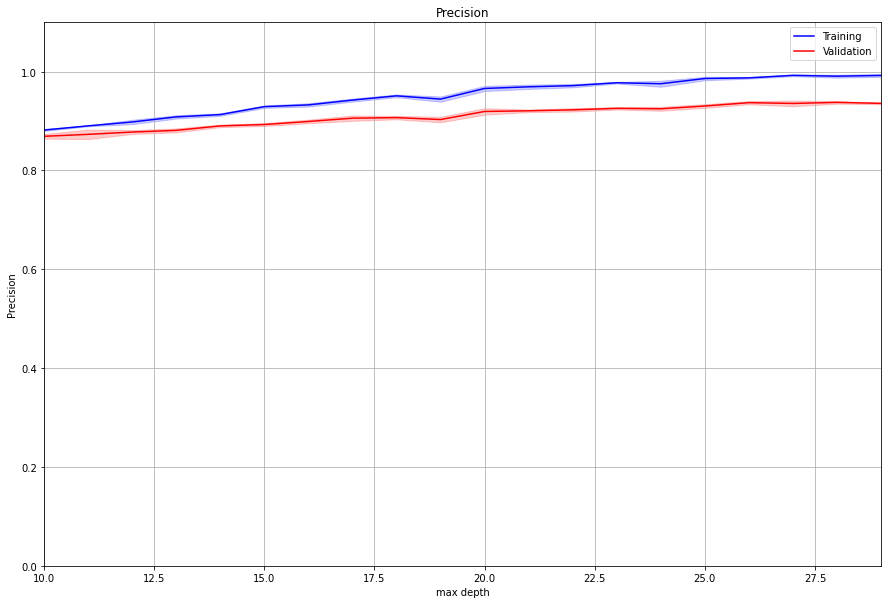

In [81]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/decision_tree_gini.png"))
else:
    (mean_trainings, std_trainings, mean_validations, std_validations) = decision_tree_influence_fixed_datasize(list(range(10, 30)), dataset_adult_75, labels_adult_75, N, loss_="manhattan",
                                         criterion='gini', folds = 5, show_time=False, visualize=True)
    print(f"Best result is {max(mean_validations)} for depth = {mean_validations.index(max(mean_validations)) + 1}")

###### Cost function = gini & weighted features

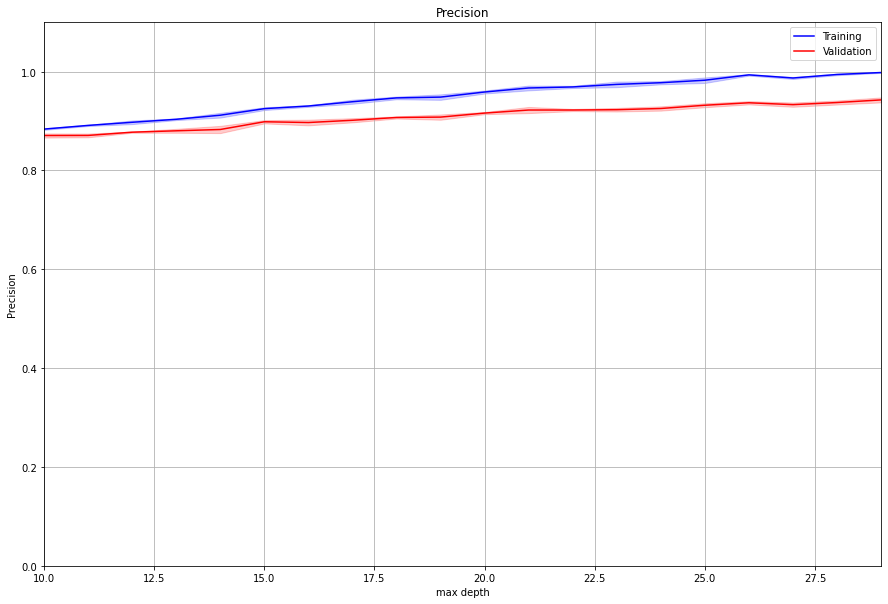

In [82]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/decision_tree_gini_weighted.png"))
else:
    (mean_trainings, std_trainings, mean_validations, std_validations) =decision_tree_influence_fixed_datasize(list(range(10, 30)), weighted_dataset_adult, labels_adult_75, N, loss_="manhattan",
                                         criterion='gini', folds = 5, show_time=False, visualize=True)

    print(f"Best result is {max(mean_validations)} for depth = {mean_validations.index(max(mean_validations)) + 1}")

###### Cost function = entropy

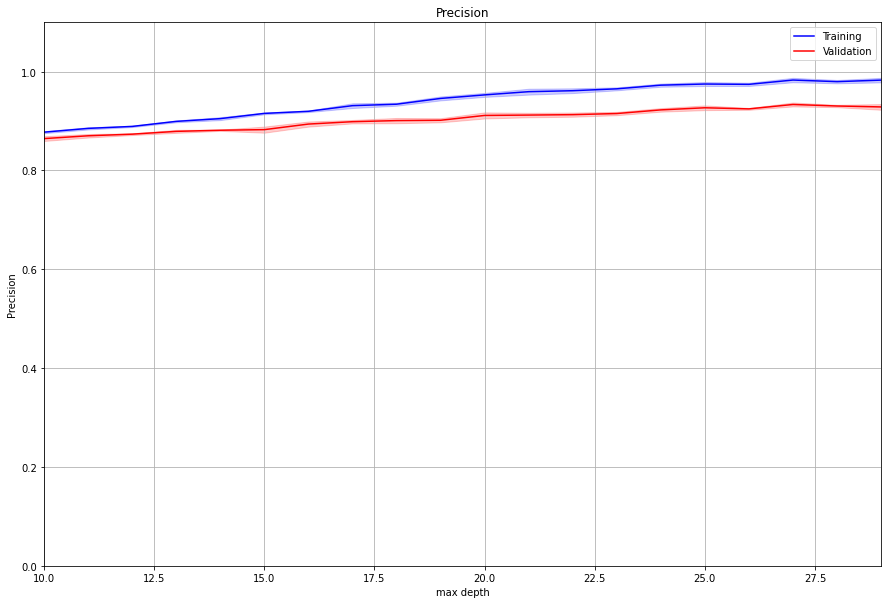

In [83]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/decision_tree_entropy.png"))
else:
    (mean_trainings, std_trainings, mean_validations, std_validations) = decision_tree_influence_fixed_datasize(list(range(10, 30)), dataset_adult_75, labels_adult_75, N, loss_="manhattan",
                                         criterion='entropy', folds = 5, show_time=False, visualize=True)
    print(f"Best result is {max(mean_validations)} for depth = {mean_validations.index(max(mean_validations)) + 1}")

###### Cost function = entropy & weighted features

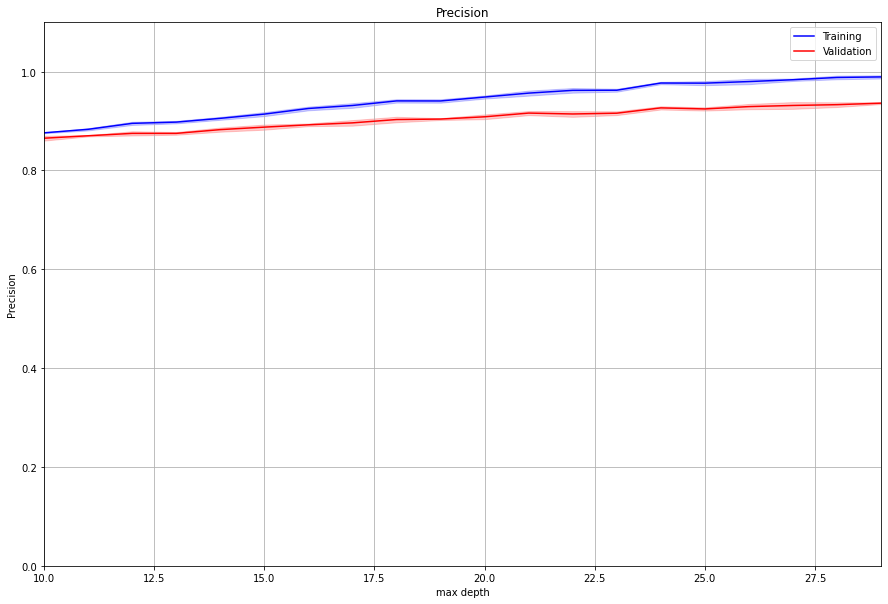

In [84]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/decision_tree_entropy_weighted.png"))
else:
    (mean_trainings, std_trainings, mean_validations, std_validations) =decision_tree_influence_fixed_datasize(list(range(10, 30)), weighted_dataset_adult, labels_adult_75, N, loss_="manhattan",
                                         criterion='entropy', folds = 5, show_time=False, visualize=True)

    print(f"Best result is {max(mean_validations)} for depth = {mean_validations.index(max(mean_validations)) + 1}")

##### Results on dataset 1

###### cost function = gini

In [85]:
depth1 = 19

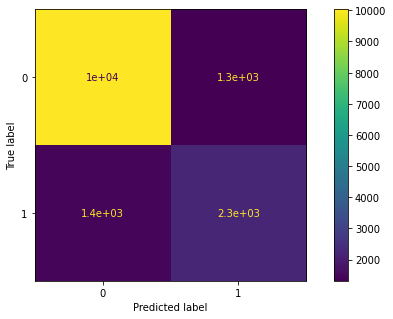

In [86]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/decision_tree_gini_test.png"))
else:
    predicted_labels1 = decision_tree(dataset_adult_75, labels_adult_75, test_dataset_adult, max_depth=depth1, criterion = "gini")
    precision1 = (len(test_labels_adult) - error(predicted_labels1, test_labels_adult))/len(test_labels_adult)
    print(f"Precision on the test dataset is {precision1}")
    disp = ConfusionMatrixDisplay(confusion_matrix(test_labels_adult, predicted_labels1), [0,1])
    disp.plot()

###### cost function = gini & weighted feature

In [87]:
depth2 = 20

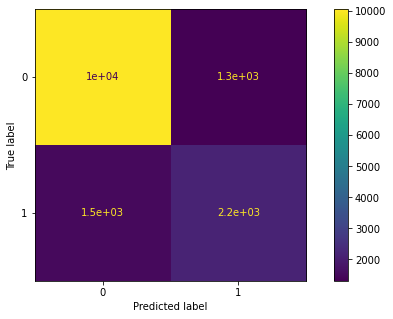

In [88]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/decision_tree_gini_weight_test.png"))
else:
    predicted_labels2 = decision_tree(weighted_dataset_adult, labels_adult_75, weighted_test_dataset_adult, max_depth=depth2, criterion='gini')
    precision2 = (len(test_labels_adult) - error(predicted_labels2, test_labels_adult))/len(test_labels_adult)
    print(f"Precision on the test dataset is {precision2}")
    disp = ConfusionMatrixDisplay(confusion_matrix(test_labels_adult, predicted_labels2), [0,1])
    disp.plot()

cost function = entropy

In [89]:
depth3 = 18

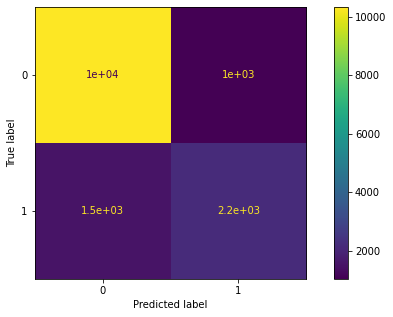

In [90]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/decision_tree_entropy_test.png"))
else:
    predicted_labels3 = decision_tree(dataset_adult_75, labels_adult_75, test_dataset_adult, max_depth=depth3, criterion = "entropy")
    precision3 = (len(test_labels_adult) - error(predicted_labels3, test_labels_adult))/len(test_labels_adult)
    print(f"Precision on the test dataset is {precision3}")
    disp = ConfusionMatrixDisplay(confusion_matrix(test_labels_adult, predicted_labels3), [0,1])
    disp.plot()

###### cost function = entropy, weighted features

In [91]:
depth4 = 20

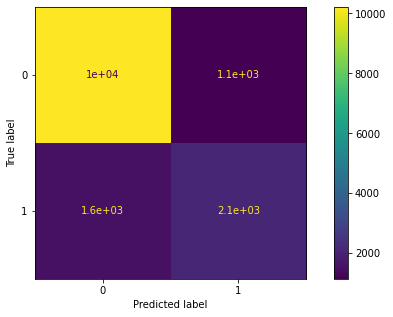

In [92]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/decision_tree_entropy_weight_test.png"))
else:
    predicted_labels4 = decision_tree(weighted_dataset_adult, labels_adult_75, weighted_test_dataset_adult, max_depth=depth4, criterion='entropy')
    precision4 = (len(test_labels_adult) - error(predicted_labels4, test_labels_adult))/len(test_labels_adult)
    print(f"Precision on the test dataset is {precision4}")
    disp = ConfusionMatrixDisplay(confusion_matrix(test_labels_adult, predicted_labels4), [0,1])
    disp.plot()

In [93]:
# Print precision and confusion matrix on test dataset

### Decision tree results for dataset 2

First we create a normalized version of the dataset, as well as a version where, after normalization, features are weighted according to the importance a decision tree algorithm gives them.

In [94]:
dataset_chess_nrows = dataset_chess.shape[0] 
normalized_dataset_chess = dataset_chess.copy(deep=True)
normalize(normalized_dataset_chess)

normalized_test_dataset_chess = test_dataset_chess.copy(deep=True)
normalize(normalized_test_dataset_chess)

weighted_dataset_chess = normalized_dataset_chess.copy(deep=True)
weights = features_importance(normalized_dataset_chess, labels_chess, criterion='gini', splitter='best')
weight_features(weighted_dataset_chess, weights)


weighted_test_dataset_chess = normalized_test_dataset_chess.copy(deep=True)
weight_features(weighted_test_dataset_chess, weights)

##### Selecting best hyperparameter

cost function = gini

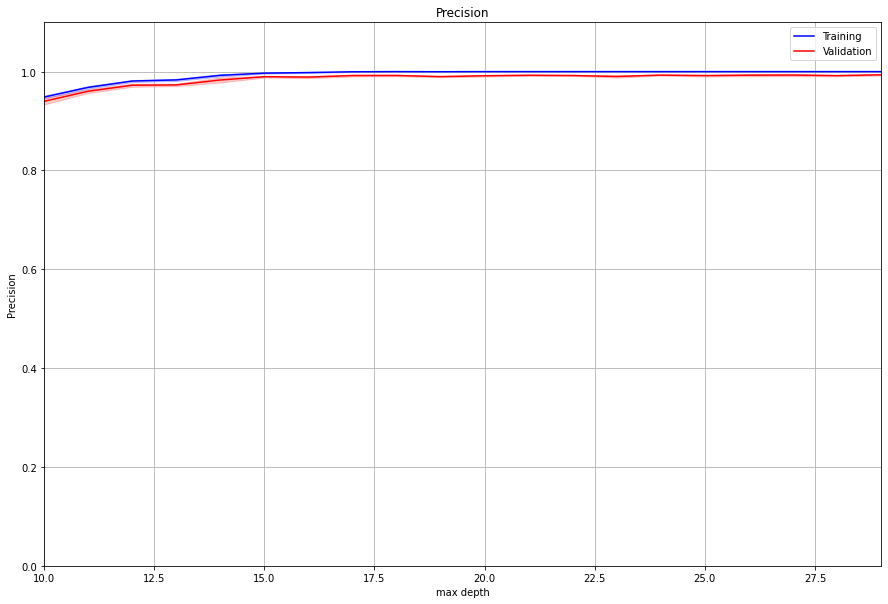

In [95]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/decision_tree_gini_chess.png"))
else:
    (mean_trainings, std_trainings, mean_validations, std_validations) =decision_tree_influence_fixed_datasize(list(range(10, 30)), dataset_chess, labels_chess, dataset_chess_nrows, loss_="manhattan",
                                         criterion="gini", folds = 5, show_time=False, visualize=True)
    print(f"Best result is {max(mean_validations)} for depth = {mean_validations.index(max(mean_validations)) + 1}")

cost function = gini and weighted feature

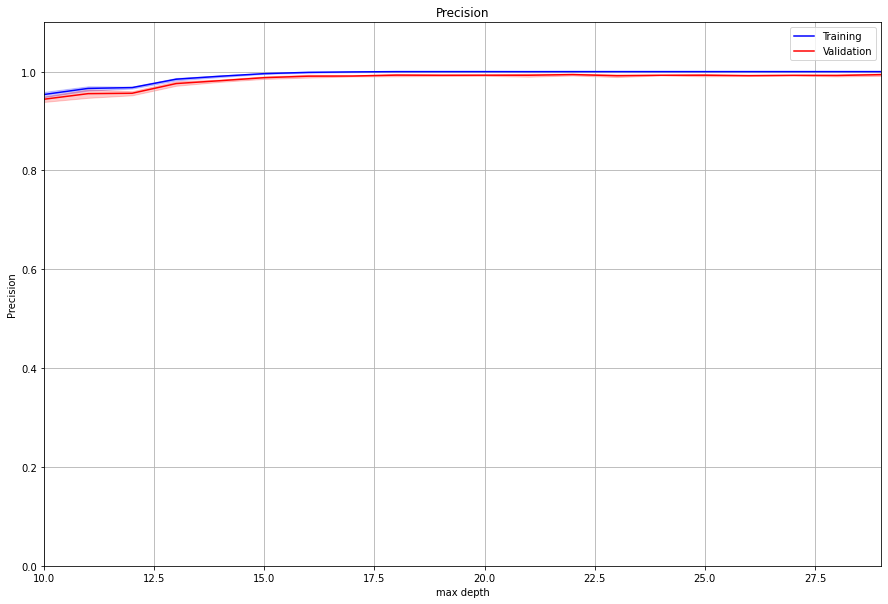

In [96]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/decision_tree_gini_weight_chess.png"))
else:
    (mean_trainings, std_trainings, mean_validations, std_validations) =decision_tree_influence_fixed_datasize(list(range(10, 30)), weighted_dataset_chess, labels_chess, dataset_chess_nrows, loss_="manhattan",
                                         criterion="gini", folds = 5, show_time=False, visualize=True)
    print(f"Best result is {max(mean_validations)} for depth = {mean_validations.index(max(mean_validations)) + 1}")

cost function = entropy

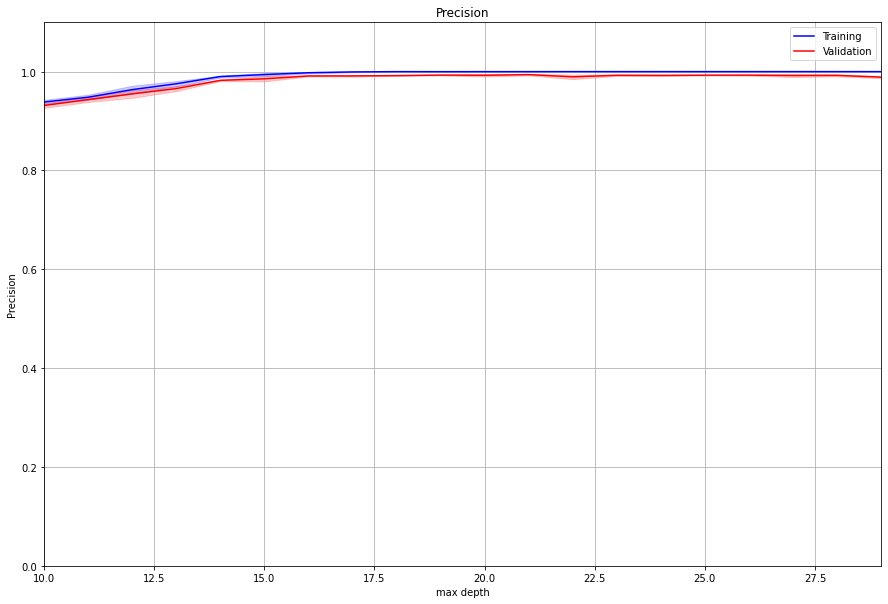

In [97]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/decision_tree_entropy_chess.png"))
else:
    (mean_trainings, std_trainings, mean_validations, std_validations) =decision_tree_influence_fixed_datasize(list(range(10, 30)), dataset_chess, labels_chess, dataset_chess_nrows, loss_="manhattan",
                                         criterion="entropy", folds = 5, show_time=False, visualize=True)
    print(f"Best result is {max(mean_validations)} for depth = {mean_validations.index(max(mean_validations)) + 1}")

cost function = entropy and weighted feature

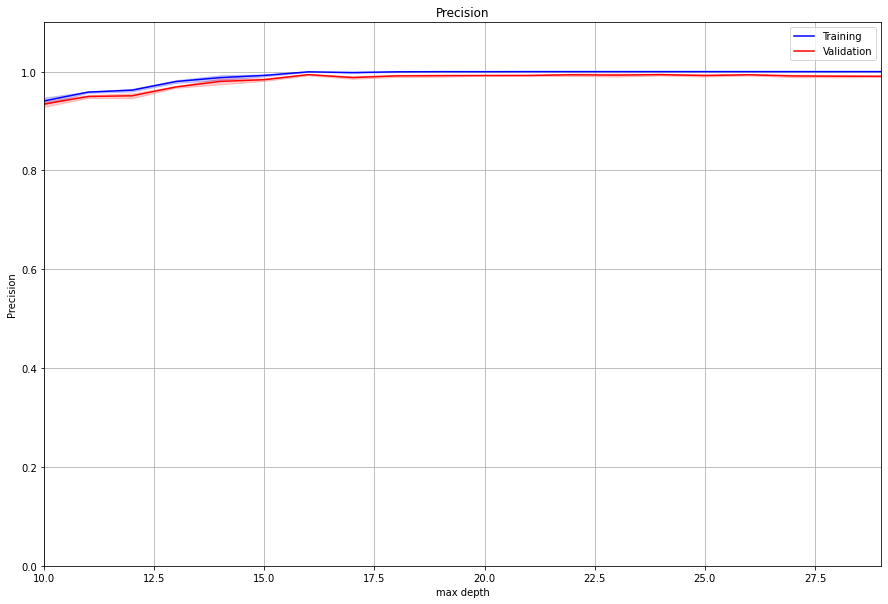

In [98]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/decision_tree_entropy_weight_chess.png"))
else:
    (mean_trainings, std_trainings, mean_validations, std_validations) =decision_tree_influence_fixed_datasize(list(range(10, 30)), weighted_dataset_chess, labels_chess, dataset_chess_nrows, loss_="manhattan",
                                         criterion="entropy", folds = 5, show_time=False, visualize=True)
    print(f"Best result is {max(mean_validations)} for depth = {mean_validations.index(max(mean_validations)) + 1}")

#### Results on dataset 2

In [99]:
depth1 = 17

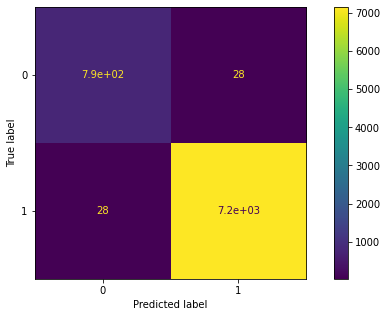

In [100]:
from sklearn.metrics import ConfusionMatrixDisplay
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/decision_tree_gini_chess_test.png"))
else:
    predicted_labels1 = decision_tree(dataset_chess, labels_chess, test_dataset_chess, max_depth=depth1, criterion = "gini")
    precision1 = (len(test_labels_chess) - error(predicted_labels1, test_labels_chess))/len(test_labels_chess)
    print(f"Precision on the test dataset is {precision1}")
    # ConfusionMatrixDisplay.from_predictions(test_labels_chess, predicted_labels1) # fro some reason this gives me an attributeError: type object 'ConfusionMatrixDisplay' has no attribute 'from_predictions'
    disp = ConfusionMatrixDisplay(confusion_matrix(test_labels_chess, predicted_labels1), [0,1])
    disp.plot()

In [101]:
depth2 = 13

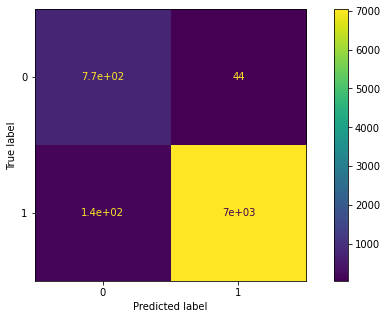

In [102]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/decision_tree_gini_weight_chess_test.png"))
else:
    predicted_labels2 = decision_tree(weighted_dataset_chess, labels_chess, weighted_test_dataset_chess, max_depth=depth2, criterion='gini')
    precision2 = (len(test_labels_chess) - error(predicted_labels2, test_labels_chess))/len(test_labels_chess)
    print(f"Precision on the test dataset is {precision2}")
    disp = ConfusionMatrixDisplay(confusion_matrix(test_labels_chess, predicted_labels2), [0,1])
    disp.plot()

In [103]:
depth3 = 12

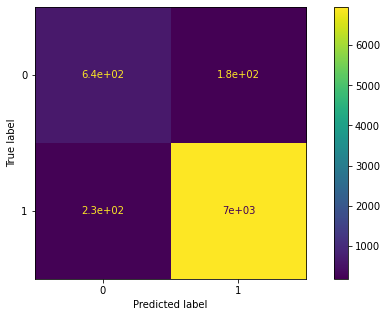

In [104]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/decision_tree_entropy_chess_test.png"))
else:
    predicted_labels3 = decision_tree(dataset_chess, labels_chess, test_dataset_chess, max_depth=depth3, criterion = "entropy")
    precision3 = (len(test_labels_chess) - error(predicted_labels3, test_labels_chess))/len(test_labels_chess)
    print(f"Precision on the test dataset is {precision3}")
    disp = ConfusionMatrixDisplay(confusion_matrix(test_labels_chess, predicted_labels3), [0, 1])
    disp.plot()

In [105]:
depth4 = 15

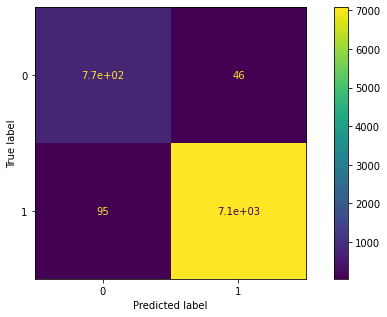

In [106]:
if(USE_IMAGES_INSTEAD_OF_COMPUTING):
    display(Image("./img/decision_tree_entropy_weight_chess_test.png"))
else:
    predicted_labels4 = decision_tree(weighted_dataset_chess, labels_chess, weighted_test_dataset_chess, max_depth=depth4, criterion='entropy')
    precision4 = (len(test_labels_chess) - error(predicted_labels4, test_labels_chess))/len(test_labels_chess)
    print(f"Precision on the test dataset is {precision4}")
    disp = ConfusionMatrixDisplay(confusion_matrix(test_labels_chess, predicted_labels4), [0, 1])
    disp.plot()